# Analysing the World Happiness Report 2024: What Factors in Most to Life Satisfaction, and Can We Really Tell?

**Introduction**

The World Hapiness Report, found at https://worldhappiness.report/, is an annual global survey which aims to provide an indication of life satisfaction across the globe in different nation territories. The World Happiness Report (WHR) is a partnership of Gallup, the Oxford Wellbeing Research Centre, the UN Sustainable Development Solutions Network, and the WHR’s Editorial Board. The report is a publication of the Wellbeing Research Centre at the University of Oxford, UK.

The dataframe for 2024's report was accessible on kaggle.com. 

This is the link to GitHub: https://github.com/simon-510/everything_counts_assignments

Disclaimer: the design of the framework of this report and written part is all my own work. Generative AI has been used to assist with code, in particular for generating visualisations (e.g. coming up with a fix for the text to show for a select few countries, being readable without overlapping, or for generating the correct plots to validate statistical tests). 

**Contextualising and Understanding the Data**

The key question posed to individuals surveyed in the sample for each country, from which responses we get an average quantified life satisfaction metric, is the question of the 'Cantril ladder': "Think of a ladder, with the best possible life for them being a 10 and the worst possible life being a 0. Respondents are then asked to rate their own current lives on that 0 to 10 scale". 

The choice of six variables that are estimated to contribute to making life evaluations ('ladder scores') higher are GDP, generosity, freedom, (lack of ) corruption, life expectancy and social support. Justifying these choices, from the World Happiness Report website: "The variables used reflect what has been broadly found in the research literature to explain national-level differences in life evaluations. Some important variables, such as unemployment or inequality, do not appear because comparable international data are not yet available for the full sample of countries."

**Sampling**

The methodology for the surveying implementation can be found at https://www.gallup.com/178667/gallup-world-poll-work.aspx.

Gallup uses a sample of at least 1000 respondents per country to get a national average of their subjective data. They conduct telephone interviews where there is reliable coverage for 80% of the population, and face-to-face ones where there is not. From their website: "The World Poll survey includes more than 100 global questions as well as region-specific items. Gallup asks residents from Australia to Pakistan the same questions, every time, in the same way." 

They go on to claim: "With some exceptions, all samples are probability based and nationally representative of the resident population aged 15 and older. The coverage area is the entire country including rural areas, and the sampling frame represents the entire civilian, non-institutionalized adult population of the country. Exceptions include areas where the safety of the interviewing staff is threatened and scarcely populated islands in some countries." They weight the samples to make them as statistically representative of the whole population as possible.

**Analysing the Data**

For the purposes of this report, we will import the 2024 data and present visualisations and regression analyses to explore the potential causal links between the Cantril Ladder score and the six other variables that are documented in that dataframe, which will be here our 'predictor' variables.

In [1]:
#Importing all the packages we will need
!pip install adjustText 
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import io
import requests
import seaborn as sns
from adjustText import adjust_text
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
%matplotlib inline 
%config InlineBackend.figure_format = 'retina'

# importing the data and printing the columns 
df_url = 'https://raw.githubusercontent.com/simon-510/everything_counts_assignments/main/World-happiness-report-2024.csv'
url_content = requests.get(df_url, verify=False).content
happiness_2024 = pd.read_csv(io.StringIO(url_content.decode('latin1')))
#happiness_2024.columns


  Using cached adjustText-1.3.0-py3-none-any.whl.metadata (3.1 kB)
Using cached adjustText-1.3.0-py3-none-any.whl (13 kB)


In [2]:
happiness_2024.columns

Index(['Country name', 'Regional indicator', 'Ladder score', 'upperwhisker',
       'lowerwhisker', 'Log GDP per capita', 'Social support',
       'Healthy life expectancy', 'Freedom to make life choices', 'Generosity',
       'Perceptions of corruption', 'Dystopia + residual'],
      dtype='object')

In [3]:
#Replacing the spaces with underscores in the column names so that statsmodels functions can work with them
print("Original Columns:", happiness_2024.columns.tolist())  # Before replacement
happiness_2024.columns = happiness_2024.columns.str.strip().str.replace(' ', '_', regex=False)
print("Modified Columns:", happiness_2024.columns.tolist())  # After replacement

Original Columns: ['Country name', 'Regional indicator', 'Ladder score', 'upperwhisker', 'lowerwhisker', 'Log GDP per capita', 'Social support', 'Healthy life expectancy', 'Freedom to make life choices', 'Generosity', 'Perceptions of corruption', 'Dystopia + residual']
Modified Columns: ['Country_name', 'Regional_indicator', 'Ladder_score', 'upperwhisker', 'lowerwhisker', 'Log_GDP_per_capita', 'Social_support', 'Healthy_life_expectancy', 'Freedom_to_make_life_choices', 'Generosity', 'Perceptions_of_corruption', 'Dystopia_+_residual']


**Visualisation of Patterns via Scatter Plots and Regression Lines**

The first thing we'll do to get a sense of the data we have is to generate a scatter plot and regression line for each of the six variables with the dependent variable, the Ladder Score. We'll be able to see intuitively where the closest relationships are, as this will help inform and guide the rigorous statistical tests we'll do afterwards, combining all the variables into a multiple linear regression model and filtering out multicollinearity. 

In [4]:
# Filter dataframe for countries with extreme values for each pair of variables that we will compare in a scatter plot, so that we can show the names of some outlying countries on each plot.

high_generosity = happiness_2024['Generosity'].quantile(0.95)
low_generosity = happiness_2024['Generosity'].quantile(0.05)
high_ladder_score = happiness_2024['Ladder_score'].quantile(0.95)
low_ladder_score = happiness_2024['Ladder_score'].quantile(0.05)
high_freedom = happiness_2024['Freedom_to_make_life_choices'].quantile(0.95)
low_freedom = happiness_2024['Freedom_to_make_life_choices'].quantile(0.05)
high_gdp = happiness_2024['Log_GDP_per_capita'].quantile(0.95)
low_gdp = happiness_2024['Log_GDP_per_capita'].quantile(0.05)
high_health = happiness_2024['Healthy_life_expectancy'].quantile(0.95)
low_health = happiness_2024['Healthy_life_expectancy'].quantile(0.05)
high_social = happiness_2024['Social_support'].quantile(0.95)
low_social = happiness_2024['Social_support'].quantile(0.05)
high_corruption = happiness_2024['Perceptions_of_corruption'].quantile(0.95)
low_corruption = happiness_2024['Perceptions_of_corruption'].quantile(0.05)

highlight_countries_generous = happiness_2024[
    (happiness_2024['Generosity'] >= high_generosity) |
    (happiness_2024['Generosity'] <= low_generosity) |
    (happiness_2024['Ladder_score'] >= high_ladder_score) |
    (happiness_2024['Ladder_score'] <= low_ladder_score)
]
highlight_countries_free_generous = happiness_2024[
    (happiness_2024['Generosity'] >= high_generosity) |
    (happiness_2024['Generosity'] <= low_generosity) |
    (happiness_2024['Freedom_to_make_life_choices'] >= high_freedom) |
    (happiness_2024['Freedom_to_make_life_choices'] <= low_freedom)
]
highlight_countries_free = happiness_2024[
    (happiness_2024['Ladder_score'] >= high_ladder_score) |
    (happiness_2024['Ladder_score'] <= low_ladder_score) |
    (happiness_2024['Freedom_to_make_life_choices'] >= high_freedom) |
    (happiness_2024['Freedom_to_make_life_choices'] <= low_freedom)
]

highlight_countries_gdp = happiness_2024[
    (happiness_2024['Ladder_score'] >= high_ladder_score) |
    (happiness_2024['Ladder_score'] <= low_ladder_score) |
    (happiness_2024['Log_GDP_per_capita'] >= high_gdp) |
    (happiness_2024['Log_GDP_per_capita'] <= low_gdp)
]

highlight_countries_health = happiness_2024[
    (happiness_2024['Ladder_score'] >= high_ladder_score) |
    (happiness_2024['Ladder_score'] <= low_ladder_score) |
    (happiness_2024['Healthy_life_expectancy'] >= high_health) |
    (happiness_2024['Healthy_life_expectancy'] <= low_health)
]

highlight_countries_social = happiness_2024[
    (happiness_2024['Ladder_score'] >= high_ladder_score) |
    (happiness_2024['Ladder_score'] <= low_ladder_score) |
    (happiness_2024['Social_support'] >= high_social) |
    (happiness_2024['Social_support'] <= low_social)
]

highlight_countries_corruption = happiness_2024[
    (happiness_2024['Ladder_score'] >= high_ladder_score) |
    (happiness_2024['Ladder_score'] <= low_ladder_score) |
    (happiness_2024['Perceptions_of_corruption'] >= high_corruption) |
    (happiness_2024['Perceptions_of_corruption'] <= low_corruption)
]

#Defining a colour scheme to display the regions of the countries on the scatter plot
unique_regions = happiness_2024['Regional_indicator'].unique()
palette = sns.color_palette("tab10", len(unique_regions)) 
region_colours = dict(zip(unique_regions, palette))  

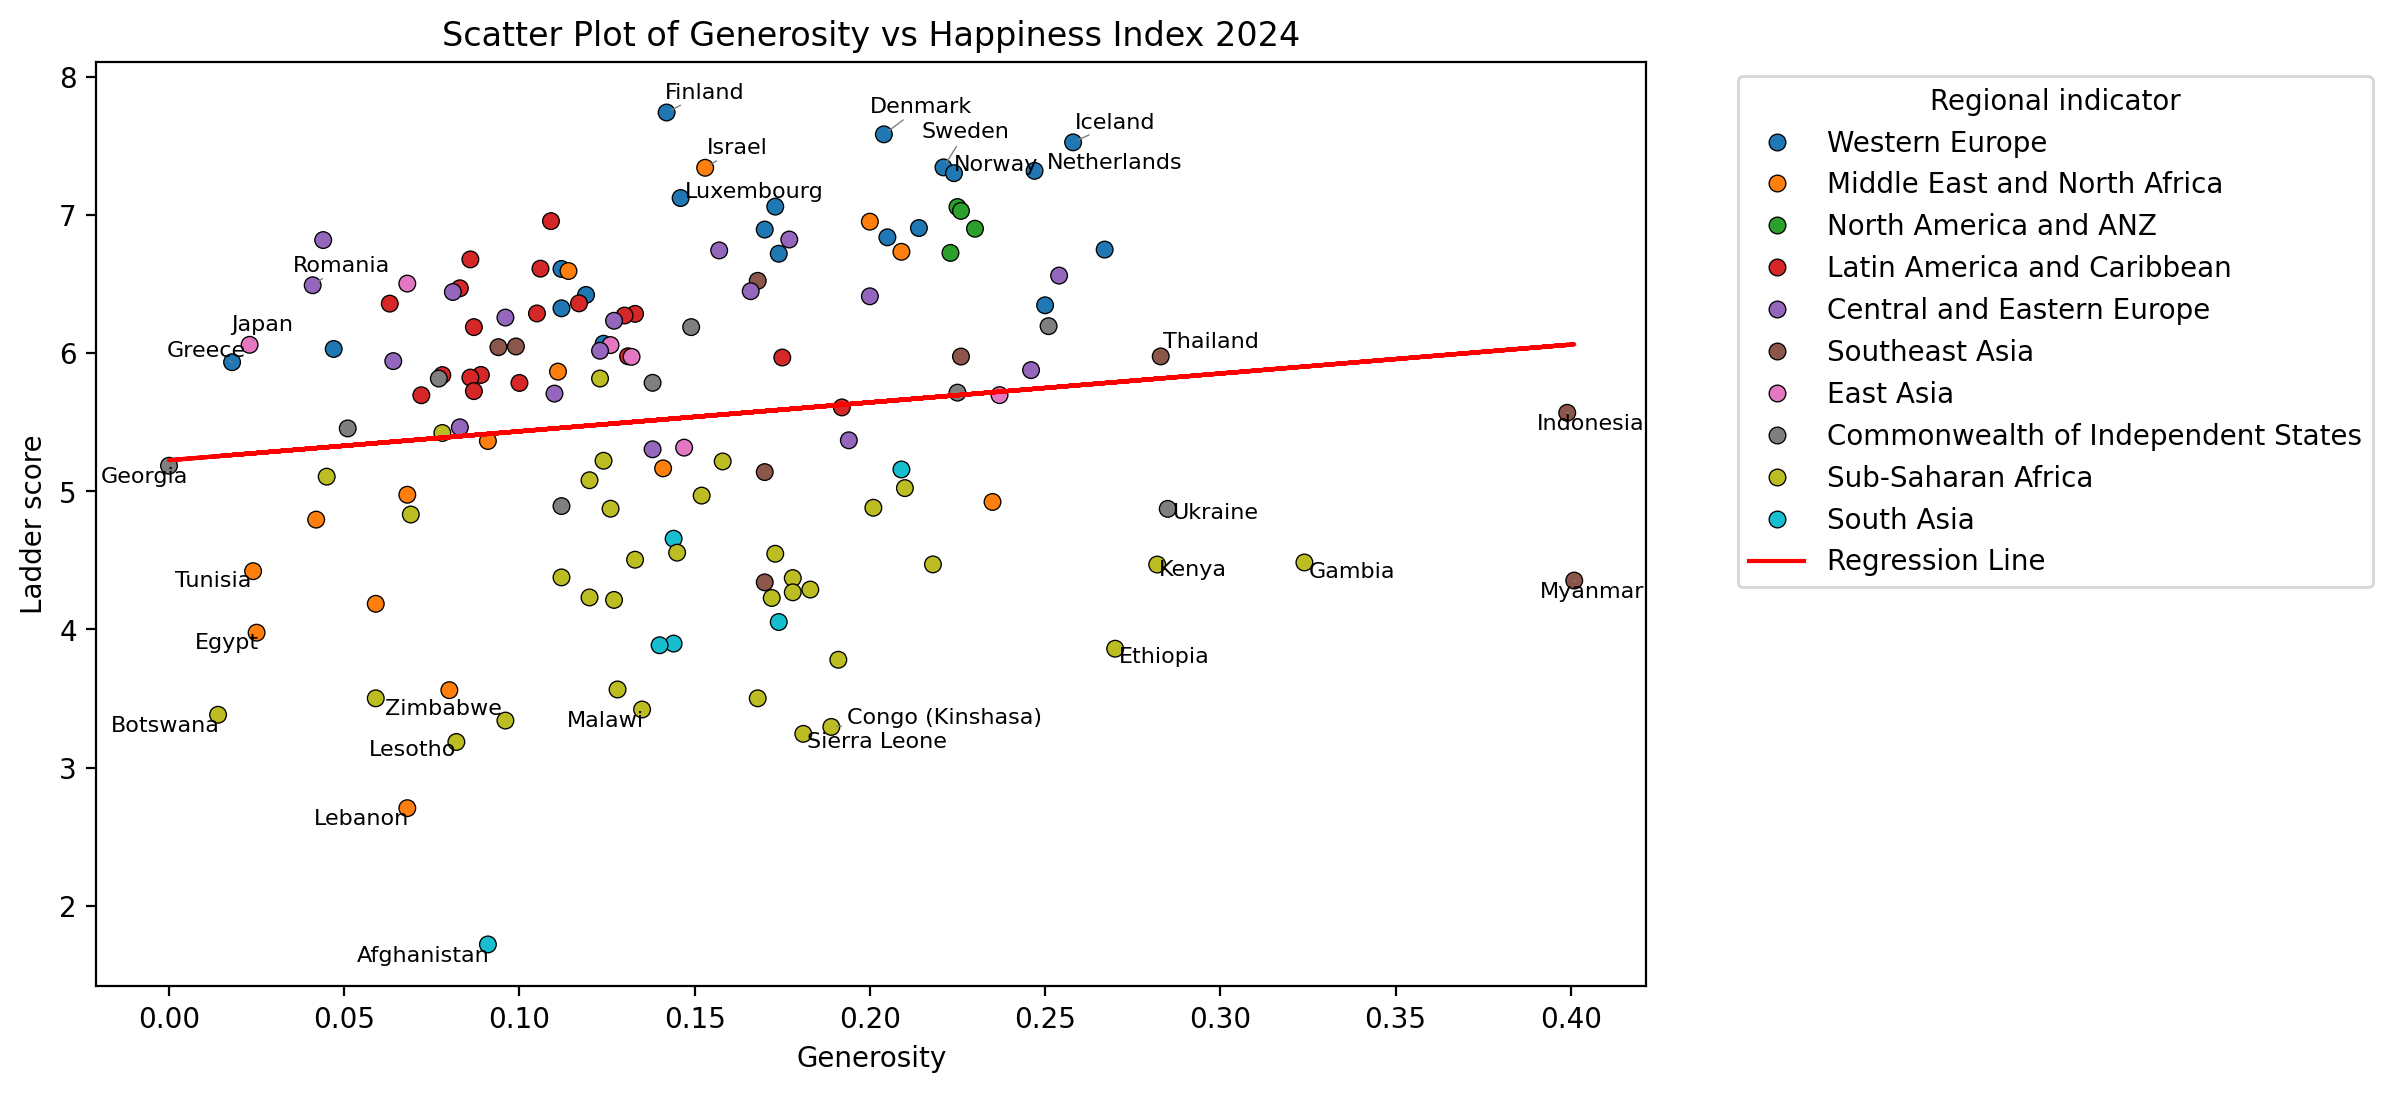

In [5]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Generosity', y='Ladder_score', data=happiness_2024, hue='Regional_indicator', palette=region_colours, edgecolor='black')

#Producing text for the outlying countries, so that we can see on the graphs which countries some of the scatter points refer to
texts=[]
for i in range(len(highlight_countries_generous)):
    country_name = highlight_countries_generous['Country_name'].iloc[i]
    x = highlight_countries_generous['Generosity'].iloc[i]
    y = highlight_countries_generous['Ladder_score'].iloc[i]
    
    # Change alignment depending on the quadrant of the point to vary positioning (so the country names don't overlap on each other)
    ha = 'left' if x > happiness_2024['Generosity'].median() else 'right'
    va = 'bottom' if y > happiness_2024['Ladder_score'].median() else 'top'
    
    # Store the text object in the list for adjustText
    texts.append(plt.text(x, y, country_name, fontsize=8, ha=ha, va=va, color='black'))

adjust_text(texts, arrowprops=dict(arrowstyle='-',color='grey', lw=0.5))

model_generous_only = smf.ols("Ladder_score ~ Generosity", data=happiness_2024).fit()

x_vals = happiness_2024['Generosity']
y_vals = model_generous_only.predict(pd.DataFrame({'Generosity': x_vals}))

# Plot the regression line
plt.plot(x_vals, y_vals, color='red', label='Regression Line')

# Title and labels
plt.title('Scatter Plot of Generosity vs Happiness Index 2024')
plt.xlabel('Generosity')
plt.ylabel('Ladder score')
plt.legend(title='Regional indicator', bbox_to_anchor=(1.05, 1), loc='upper left')

# Show plot
plt.show()

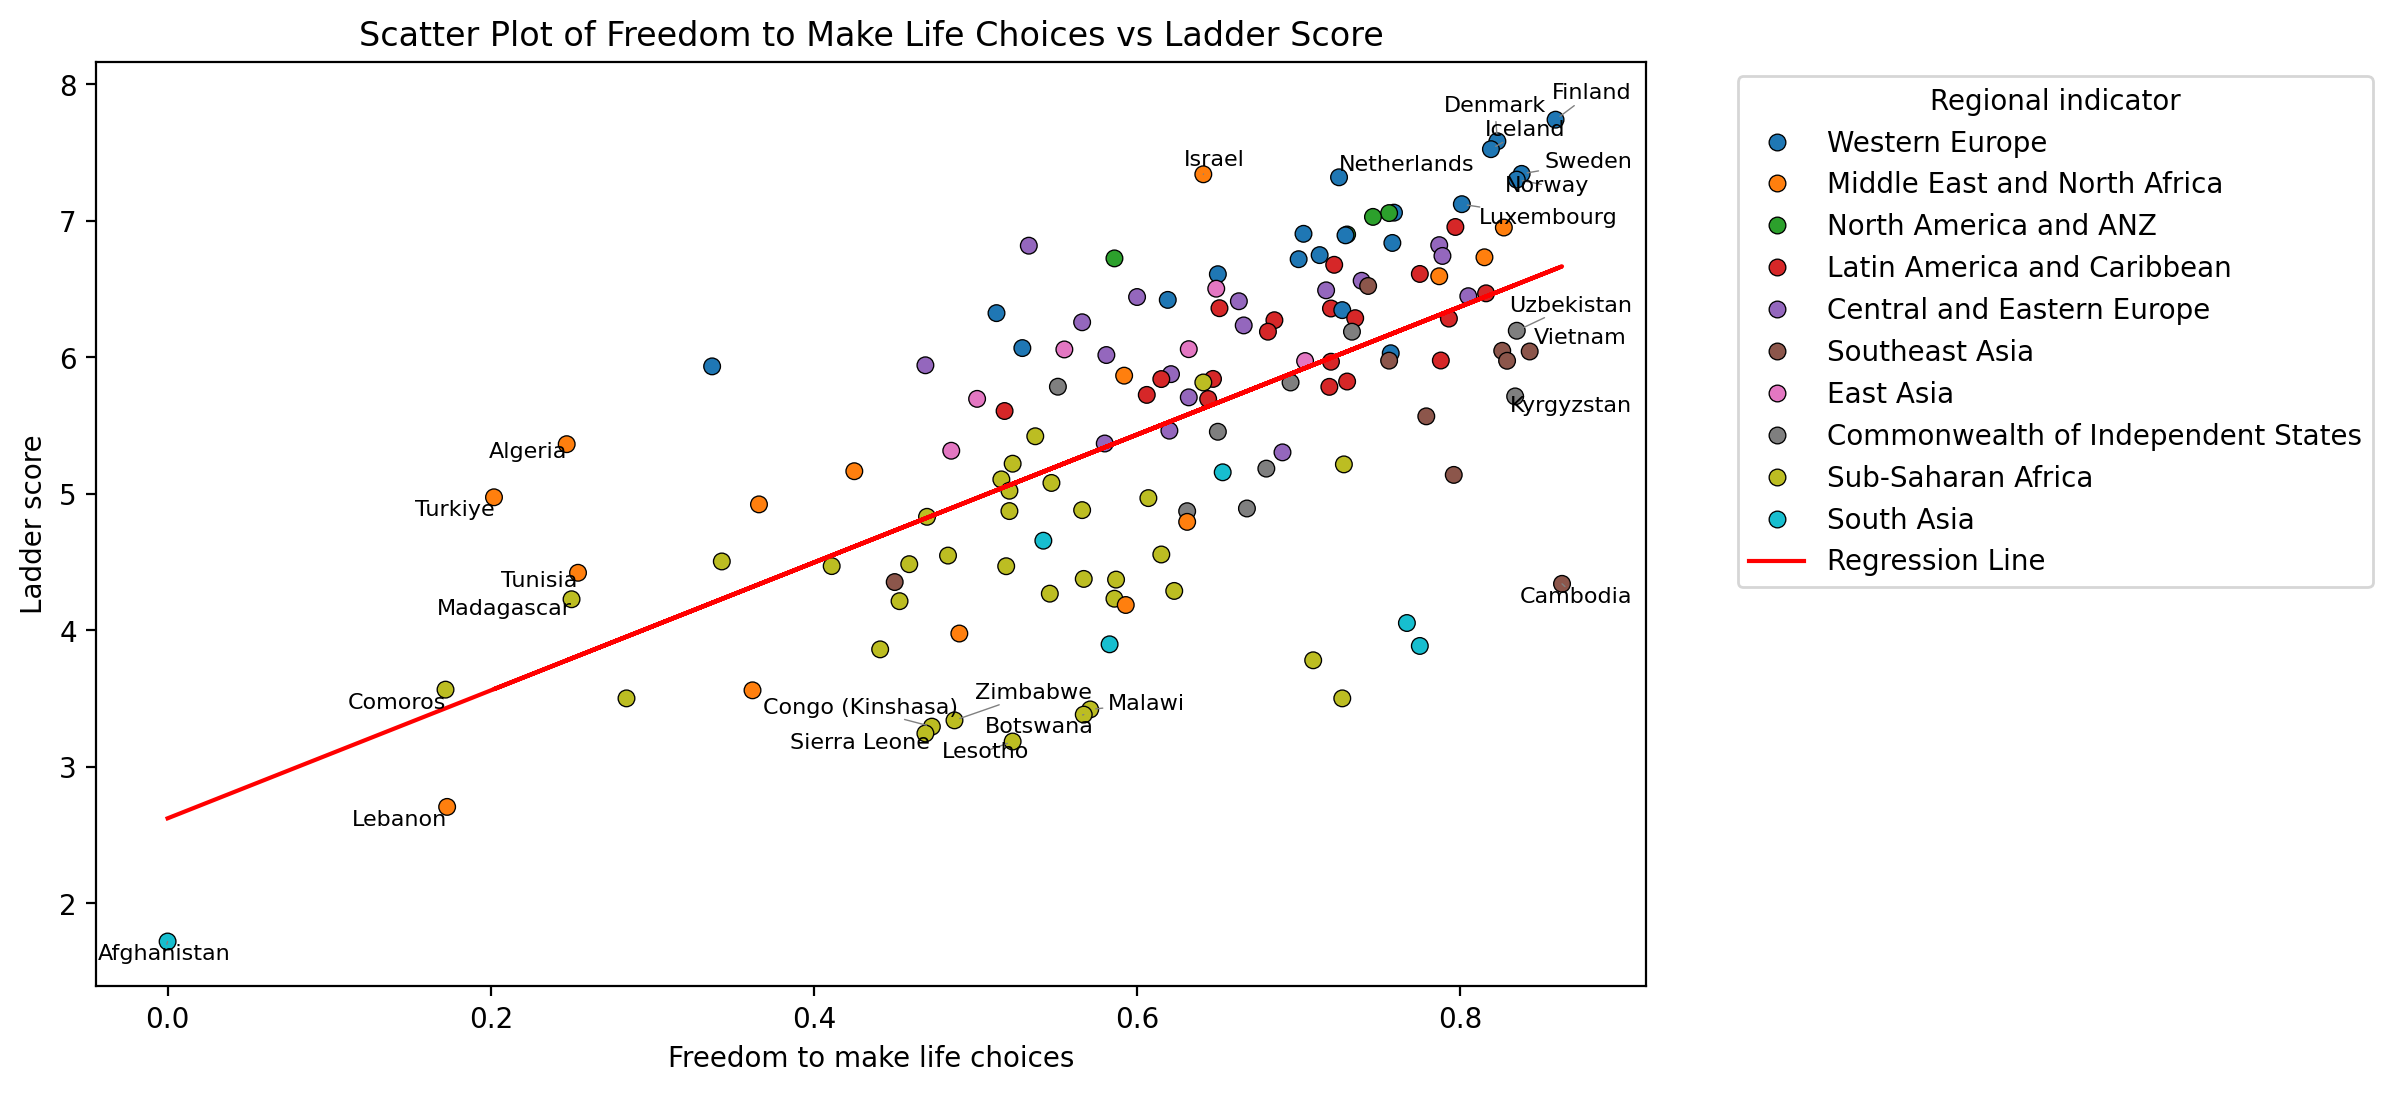

In [6]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Freedom_to_make_life_choices', y='Ladder_score', data=happiness_2024, hue='Regional_indicator', palette=region_colours, edgecolor='black')

#Producing text for the outlying countries, so that we can see on the graphs which countries some of the scatter points refer to
texts=[]
for i in range(len(highlight_countries_free)):
    country_name = highlight_countries_free['Country_name'].iloc[i]
    x = highlight_countries_free['Freedom_to_make_life_choices'].iloc[i]
    y = highlight_countries_free['Ladder_score'].iloc[i]
    
    # Change alignment depending on the quadrant of the point to vary positioning
    ha = 'left' if x > happiness_2024['Freedom_to_make_life_choices'].median() else 'right'
    va = 'bottom' if y > happiness_2024['Ladder_score'].median() else 'top'
    
    # Store the text object in the list for adjustText
    texts.append(plt.text(x, y, country_name, fontsize=8, ha=ha, va=va, color='black'))

adjust_text(texts, arrowprops=dict(arrowstyle='-',color='grey', lw=0.5))

model_freedom_only = smf.ols("Ladder_score ~ Freedom_to_make_life_choices", data=happiness_2024).fit()

x_vals = happiness_2024['Freedom_to_make_life_choices']
y_vals = model_freedom_only.predict(pd.DataFrame({'Freedom_to_make_life_choices': x_vals}))

# Plot the regression line
plt.plot(x_vals, y_vals, color='red', label='Regression Line')

# Title and labels
plt.title('Scatter Plot of Freedom to Make Life Choices vs Ladder Score')
plt.xlabel('Freedom to make life choices')
plt.ylabel('Ladder score')
plt.legend(title='Regional indicator', bbox_to_anchor=(1.05, 1), loc='upper left')

# Show plot
plt.show()

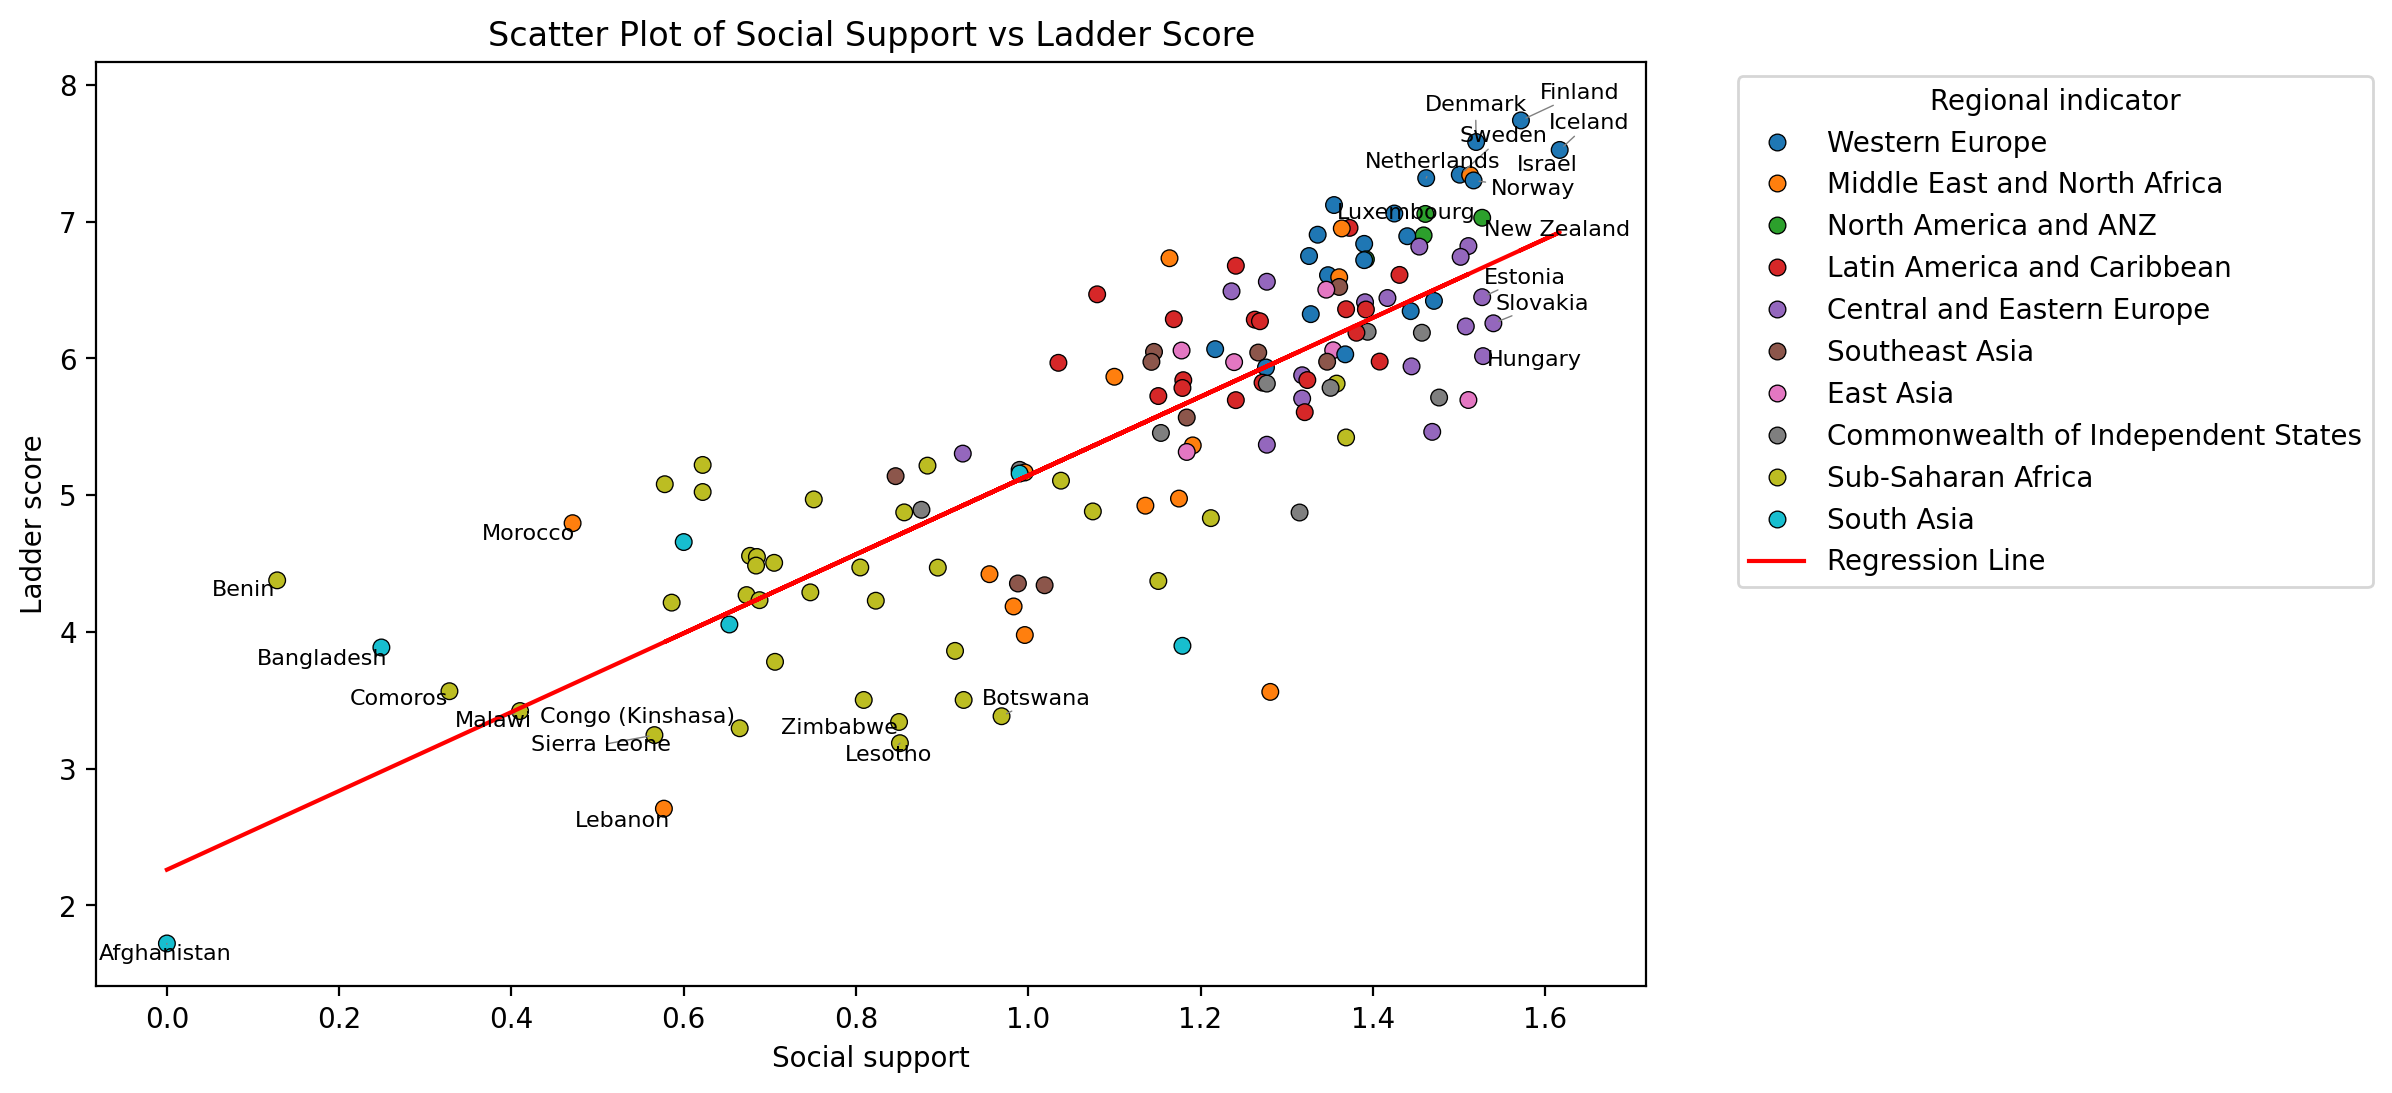

In [7]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Social_support', y='Ladder_score', data=happiness_2024, hue='Regional_indicator', palette=region_colours, edgecolor='black')

#Producing text for the outlying countries, so that we can see on the graphs which countries some of the scatter points refer to
texts=[]
for i in range(len(highlight_countries_social)):
    country_name = highlight_countries_social['Country_name'].iloc[i]
    x = highlight_countries_social['Social_support'].iloc[i]
    y = highlight_countries_social['Ladder_score'].iloc[i]
    
    # Change alignment depending on the quadrant of the point to vary positioning
    ha = 'left' if x > happiness_2024['Social_support'].median() else 'right'
    va = 'bottom' if y > happiness_2024['Ladder_score'].median() else 'top'
    
    # Store the text object in the list for adjustText
    texts.append(plt.text(x, y, country_name, fontsize=8, ha=ha, va=va, color='black'))

adjust_text(texts, arrowprops=dict(arrowstyle='-',color='grey', lw=0.5))

model_social_only = smf.ols("Ladder_score ~ Social_support", data=happiness_2024).fit()

x_vals = happiness_2024['Social_support']
y_vals = model_social_only.predict(pd.DataFrame({'Social_support': x_vals}))

# Plot the regression line
plt.plot(x_vals, y_vals, color='red', label='Regression Line')

# Title and labels
plt.title('Scatter Plot of Social Support vs Ladder Score')
plt.xlabel('Social support')
plt.ylabel('Ladder score')
plt.legend(title='Regional indicator', bbox_to_anchor=(1.05, 1), loc='upper left')

# Show plot
plt.show()

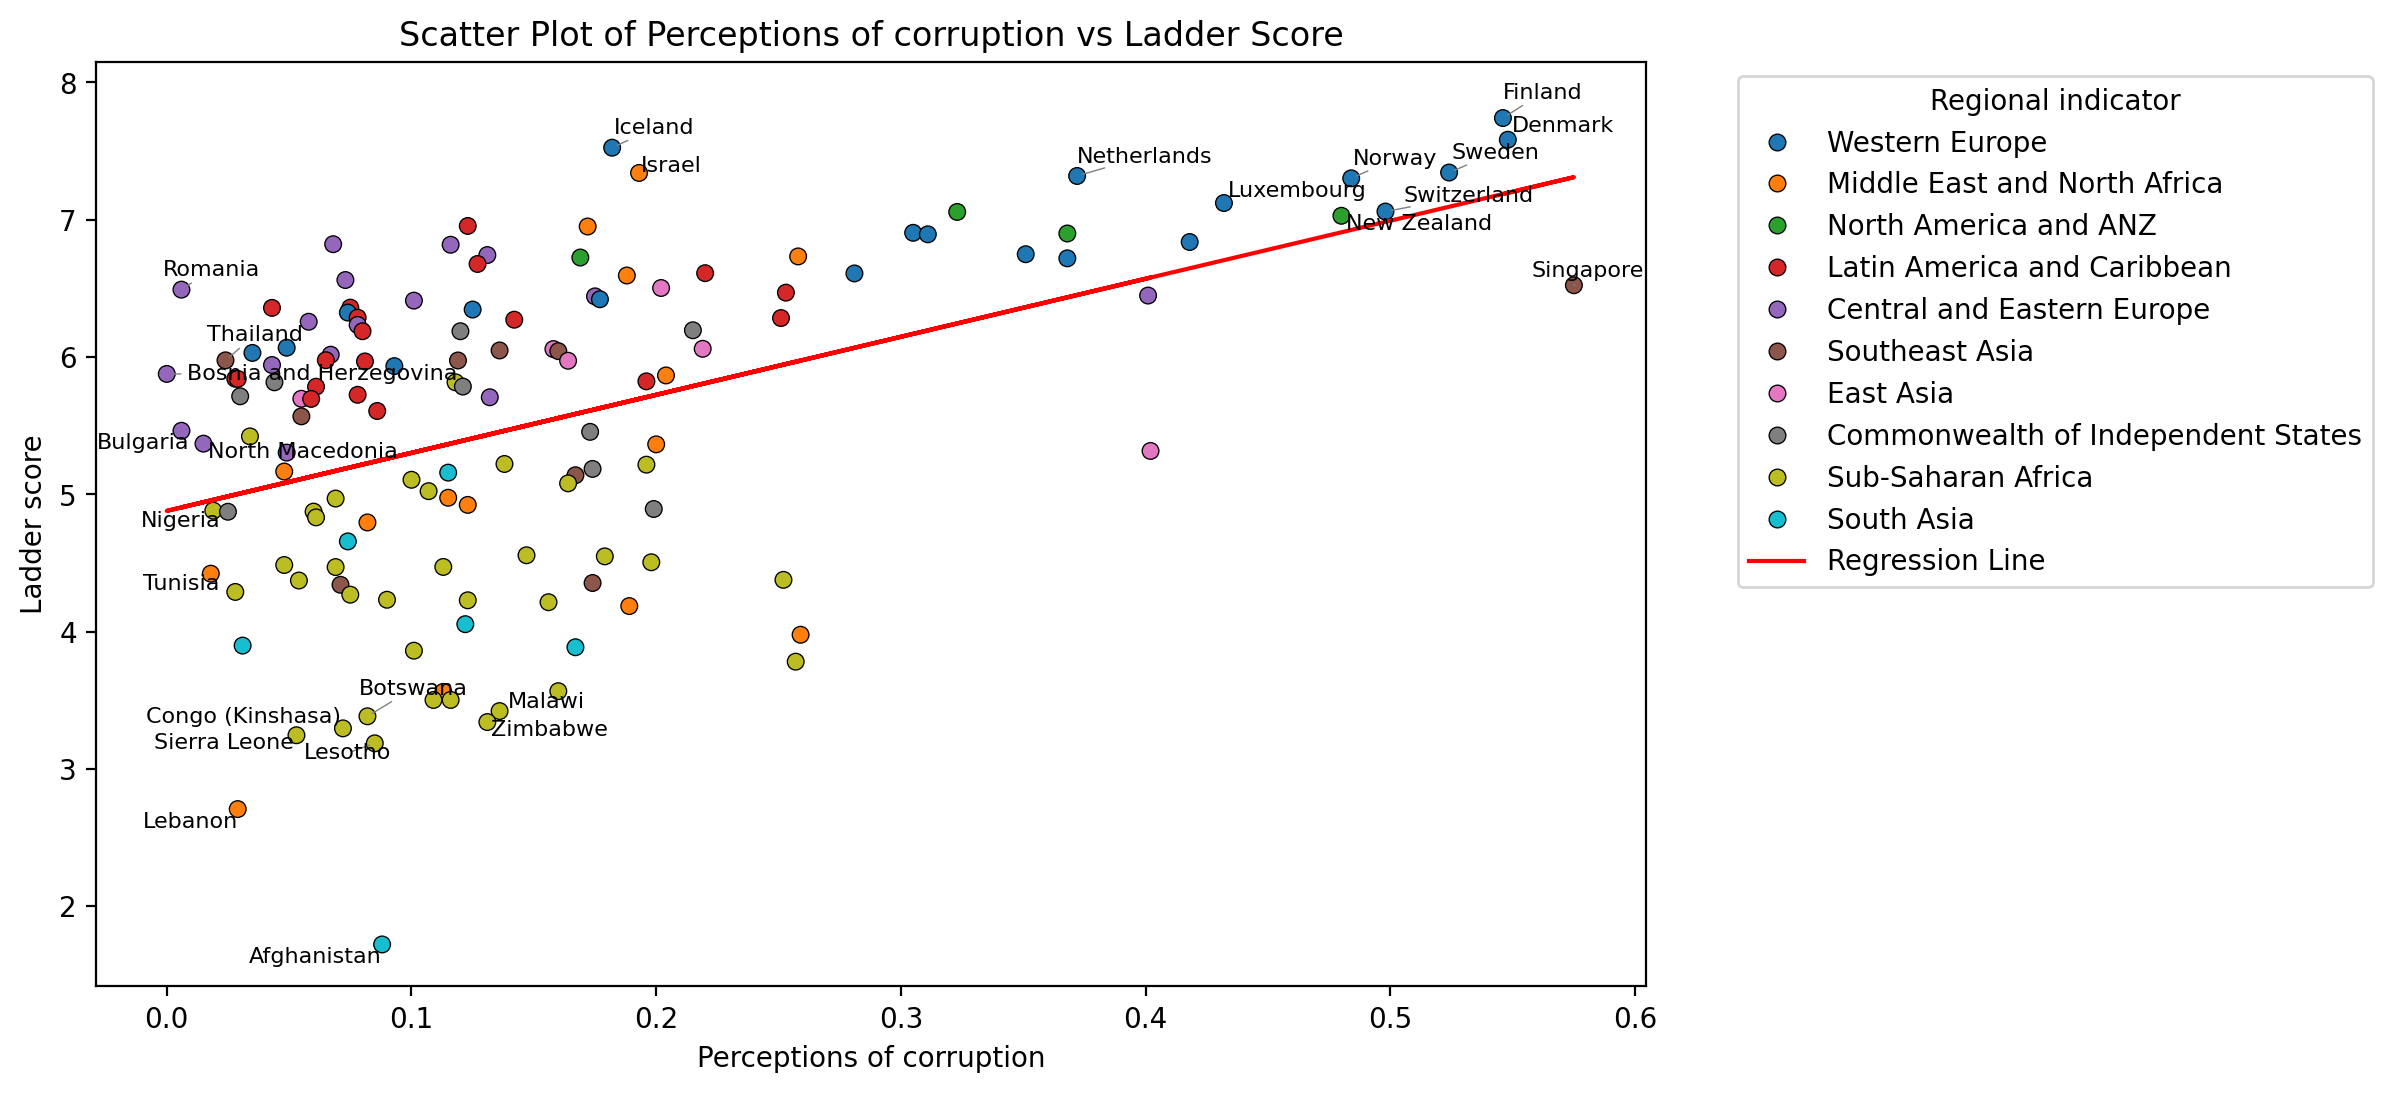

In [8]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Perceptions_of_corruption', y='Ladder_score', data=happiness_2024, hue='Regional_indicator', palette=region_colours, edgecolor='black')

#Producing text for the outlying countries, so that we can see on the graphs which countries some of the scatter points refer to
texts=[]
for i in range(len(highlight_countries_corruption)):
    country_name = highlight_countries_corruption['Country_name'].iloc[i]
    x = highlight_countries_corruption['Perceptions_of_corruption'].iloc[i]
    y = highlight_countries_corruption['Ladder_score'].iloc[i]
    
    # Change alignment depending on the quadrant of the point to vary positioning
    ha = 'left' if x > happiness_2024['Perceptions_of_corruption'].median() else 'right'
    va = 'bottom' if y > happiness_2024['Ladder_score'].median() else 'top'
    
    # Store the text object in the list for adjustText
    texts.append(plt.text(x, y, country_name, fontsize=8, ha=ha, va=va, color='black'))

adjust_text(texts, arrowprops=dict(arrowstyle='-',color='grey', lw=0.5))

model_corruption_only = smf.ols("Ladder_score ~ Perceptions_of_corruption", data=happiness_2024).fit()

x_vals = happiness_2024['Perceptions_of_corruption']
y_vals = model_corruption_only.predict(pd.DataFrame({'Perceptions_of_corruption': x_vals}))

# Plot the regression line
plt.plot(x_vals, y_vals, color='red', label='Regression Line')

# Title and labels
plt.title('Scatter Plot of Perceptions of corruption vs Ladder Score')
plt.xlabel('Perceptions of corruption')
plt.ylabel('Ladder score')
plt.legend(title='Regional indicator', bbox_to_anchor=(1.05, 1), loc='upper left')

# Show plot
plt.show()

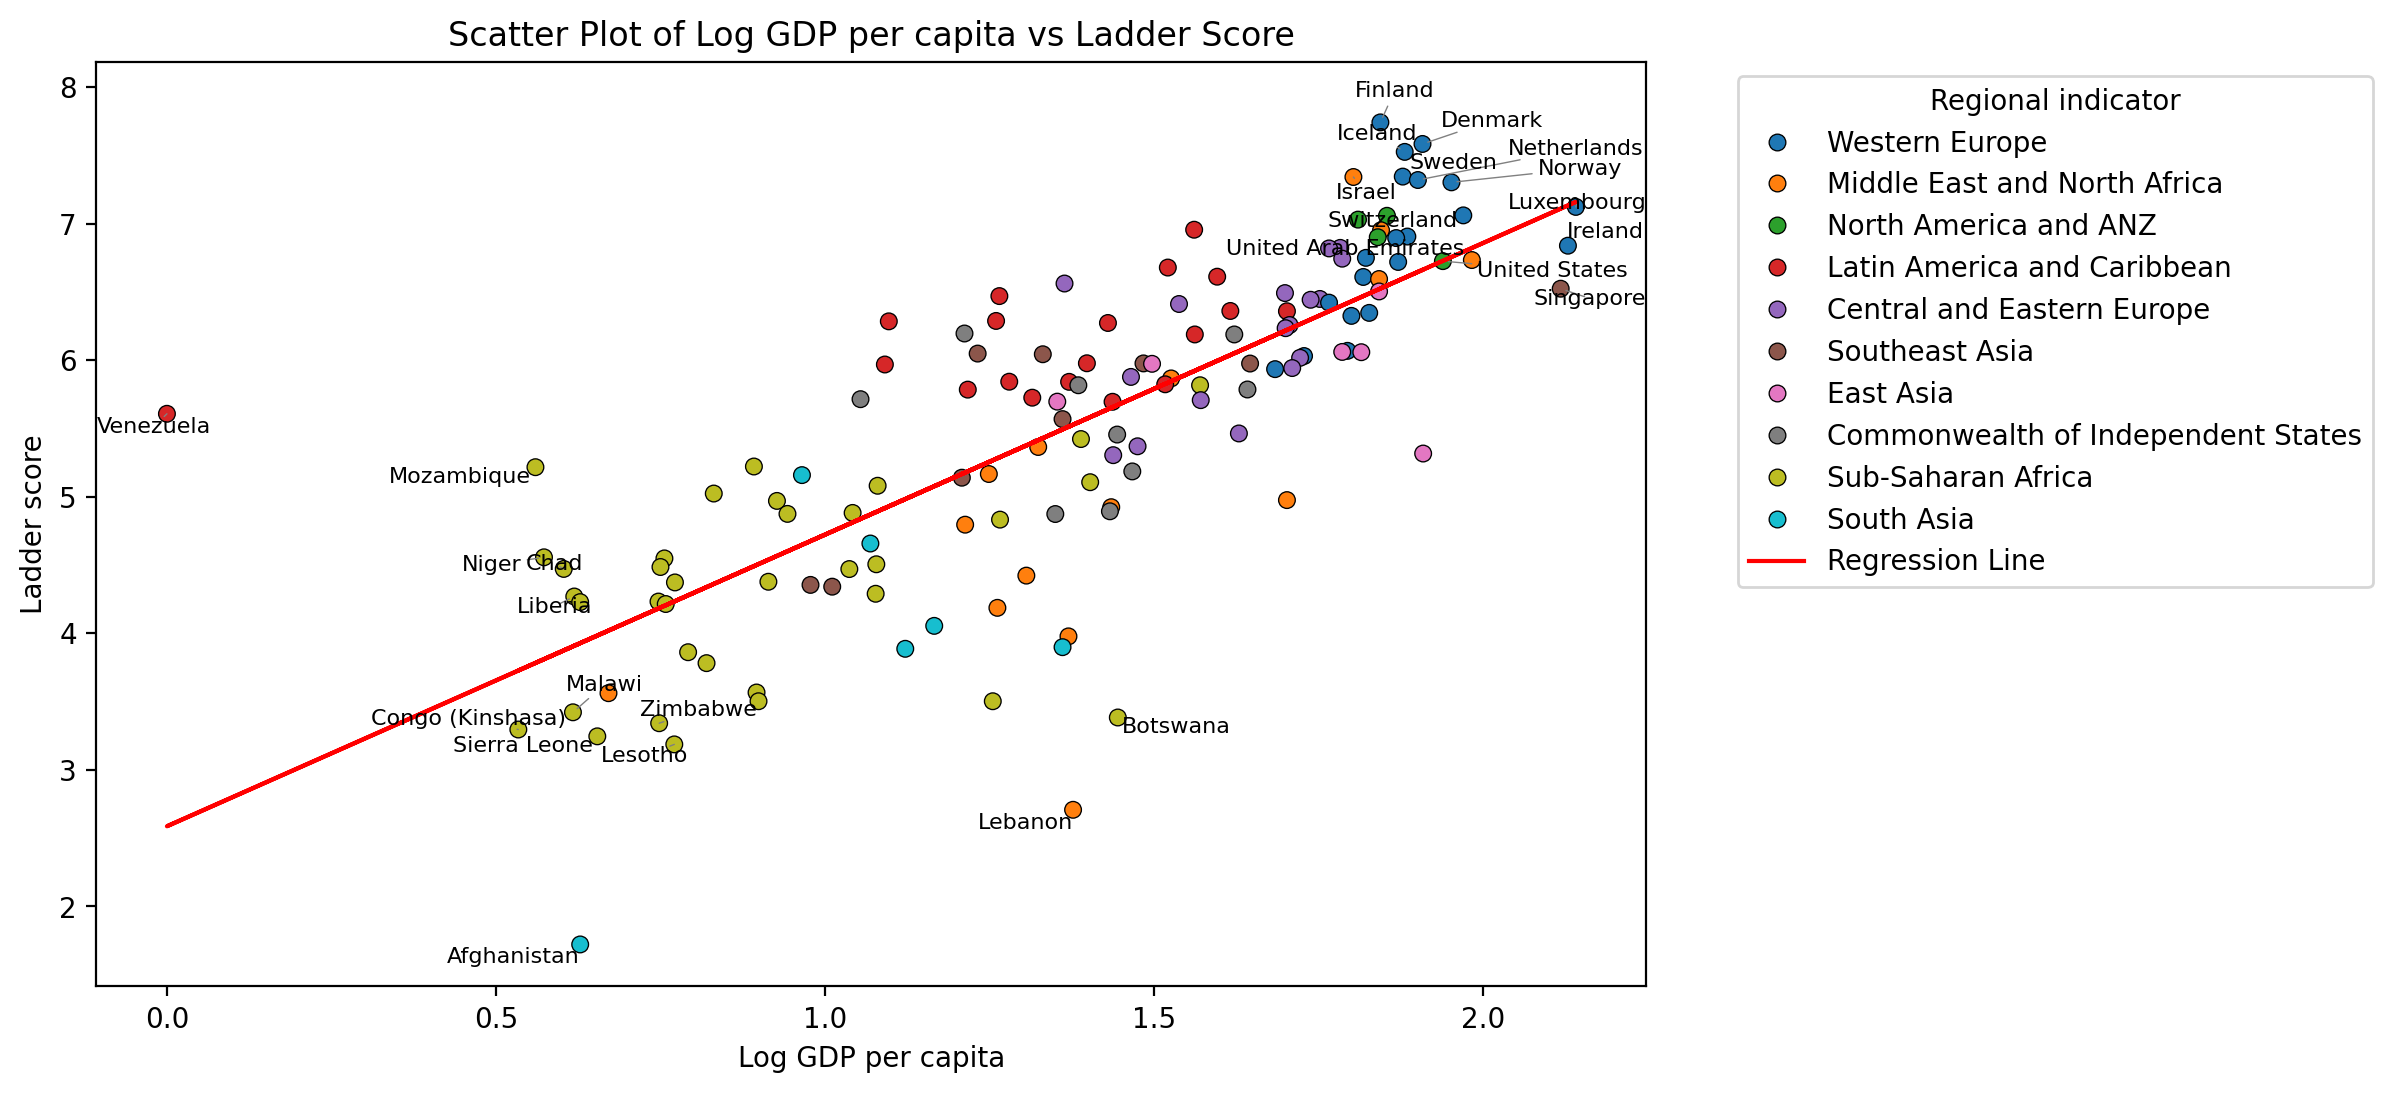

In [9]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Log_GDP_per_capita', y='Ladder_score', data=happiness_2024, hue='Regional_indicator', palette=region_colours, edgecolor='black')

#Producing text for the outlying countries, so that we can see on the graphs which countries some of the scatter points refer to
texts = []
for i in range(len(highlight_countries_gdp)):
    country_name = highlight_countries_gdp['Country_name'].iloc[i]
    x = highlight_countries_gdp['Log_GDP_per_capita'].iloc[i]
    y = highlight_countries_gdp['Ladder_score'].iloc[i]
    
    # Adjust text alignment
    ha = 'left' if x > happiness_2024['Log_GDP_per_capita'].median() else 'right'
    va = 'bottom' if y > happiness_2024['Ladder_score'].median() else 'top'
    
    # Add country names
    texts.append(plt.text(x, y, country_name, fontsize=8, ha=ha, va=va, color='black'))

adjust_text(texts, arrowprops=dict(arrowstyle='-', color='grey', lw=0.5))

model_gdp_only = smf.ols("Ladder_score ~ Log_GDP_per_capita", data=happiness_2024).fit()

x_vals = happiness_2024['Log_GDP_per_capita']
y_vals = model_gdp_only.predict(pd.DataFrame({'Log_GDP_per_capita': x_vals}))

# Regression line
plt.plot(x_vals, y_vals, color='red', label='Regression Line')

# Title and labels
plt.title('Scatter Plot of Log GDP per capita vs Ladder Score')
plt.xlabel('Log GDP per capita')
plt.ylabel('Ladder score')
plt.legend(title='Regional indicator', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.show()


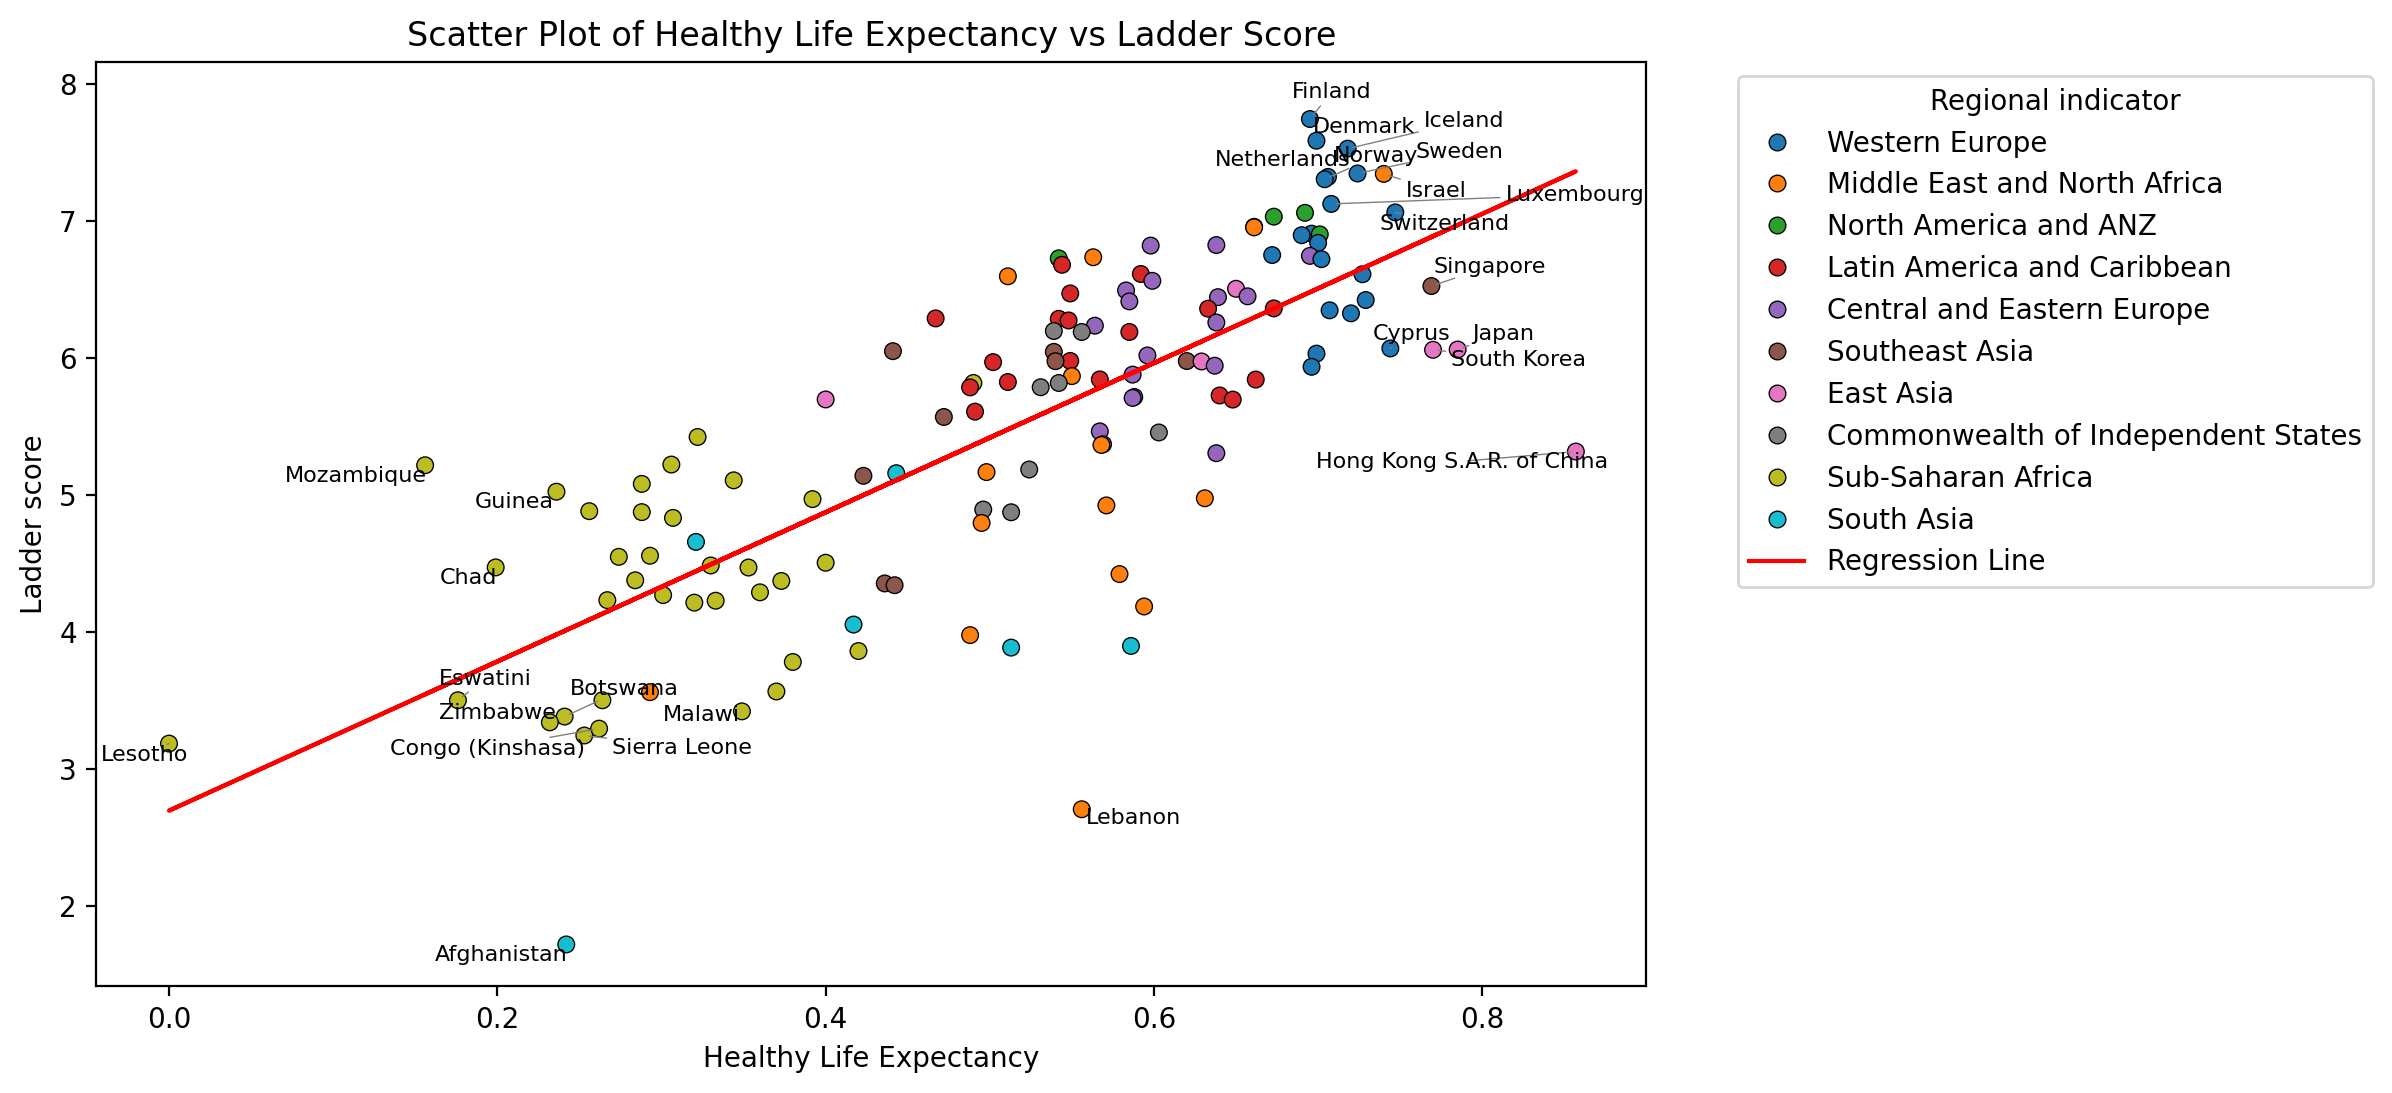

In [10]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Healthy_life_expectancy', y='Ladder_score', data=happiness_2024, hue='Regional_indicator', palette=region_colours, edgecolor='black')

#Producing text for the outlying countries, so that we can see on the graphs which countries some of the scatter points refer to
texts = []
for i in range(len(highlight_countries_health)):
    country_name = highlight_countries_health['Country_name'].iloc[i]
    x = highlight_countries_health['Healthy_life_expectancy'].iloc[i]
    y = highlight_countries_health['Ladder_score'].iloc[i]
    
    # Adjust text alignment
    ha = 'left' if x > happiness_2024['Healthy_life_expectancy'].median() else 'right'
    va = 'bottom' if y > happiness_2024['Ladder_score'].median() else 'top'
    
    # Add country names
    texts.append(plt.text(x, y, country_name, fontsize=8, ha=ha, va=va, color='black'))

adjust_text(texts, arrowprops=dict(arrowstyle='-', color='grey', lw=0.5))

model_health_only = smf.ols("Ladder_score ~ Healthy_life_expectancy", data=happiness_2024).fit()

x_vals = happiness_2024['Healthy_life_expectancy']
y_vals = model_health_only.predict(pd.DataFrame({'Healthy_life_expectancy': x_vals}))

# Regression line
plt.plot(x_vals, y_vals, color='red', label='Regression Line')

# Title and labels
plt.title('Scatter Plot of Healthy Life Expectancy vs Ladder Score')
plt.xlabel('Healthy Life Expectancy')
plt.ylabel('Ladder score')
plt.legend(title='Regional indicator', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.show()


Observing the shape of these linear regression plots, some variables appear to better predict the Ladder Score than others. Most of them can be seen to exhibit a linear relationship, though the corruption plot could perhaps be better fit with a non-linear model. One variable stands out most for its seemingly weak capacity to predict the Ladder Score: generosity. The regression line is only tilted very slightly positively. If generosity is not much of a predictor of overall life satisfaction, why has it been included? Is there an interesting relationship between generosity and some of the other predictor variables?

**Generosity Test**

Let's explore the generosity variable some more, by modelling for regression with generosity as the dependent variable. Below is the summary for predicting generosity from the Ladder score - going 'backwards' compared to the models used to generate the scatter plots, which all had Ladder Score as the dependent. The relationship again appears weak - the $p$-value would be too high to pass many hypothesis tests for describing a relationship between these variables. 

In [11]:
formula_string = "Generosity ~ Ladder_score"
model = sm.formula.ols(formula = formula_string, data = happiness_2024)
model_happiness = model.fit()

print(model_happiness.summary())

                            OLS Regression Results                            
Dep. Variable:             Generosity   R-squared:                       0.017
Model:                            OLS   Adj. R-squared:                  0.010
Method:                 Least Squares   F-statistic:                     2.374
Date:                Thu, 21 Nov 2024   Prob (F-statistic):              0.126
Time:                        19:52:13   Log-Likelihood:                 168.62
No. Observations:                 140   AIC:                            -333.2
Df Residuals:                     138   BIC:                            -327.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        0.1016      0.030      3.422   

How about predicting Generosity from one of the other variables, Freedom to Make Life Choices? Generosity is a 'life choice', so where people have more freedom could that lead to them being more generous? 

Let's set up a hypothesis test:
- **Null Hypothesis** (H₀): There is no relationship between freedom to make life choices and generosity.
- **Alternative Hypothesis** (H₁): There is a positive relationship between freedom to make life choices and generosity.
- We will run a 95% significance level, so the Null Hypothesis would not be accepted if the $p$-value for the Freedom to make life choices coefficient in the regression output is less than 0.05. 

Here we run an Ordinary Least Squares regression, a scatter plot and a residuals plot to inform our analysis:

In [12]:
formula_string = "Generosity ~ Freedom_to_make_life_choices"
model = sm.formula.ols(formula = formula_string, data = happiness_2024)
model_freedom = model.fit()

print(model_freedom.summary())

                            OLS Regression Results                            
Dep. Variable:             Generosity   R-squared:                       0.050
Model:                            OLS   Adj. R-squared:                  0.043
Method:                 Least Squares   F-statistic:                     7.312
Date:                Thu, 21 Nov 2024   Prob (F-statistic):            0.00771
Time:                        19:52:17   Log-Likelihood:                 171.04
No. Observations:                 140   AIC:                            -338.1
Df Residuals:                     138   BIC:                            -332.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Intercept       

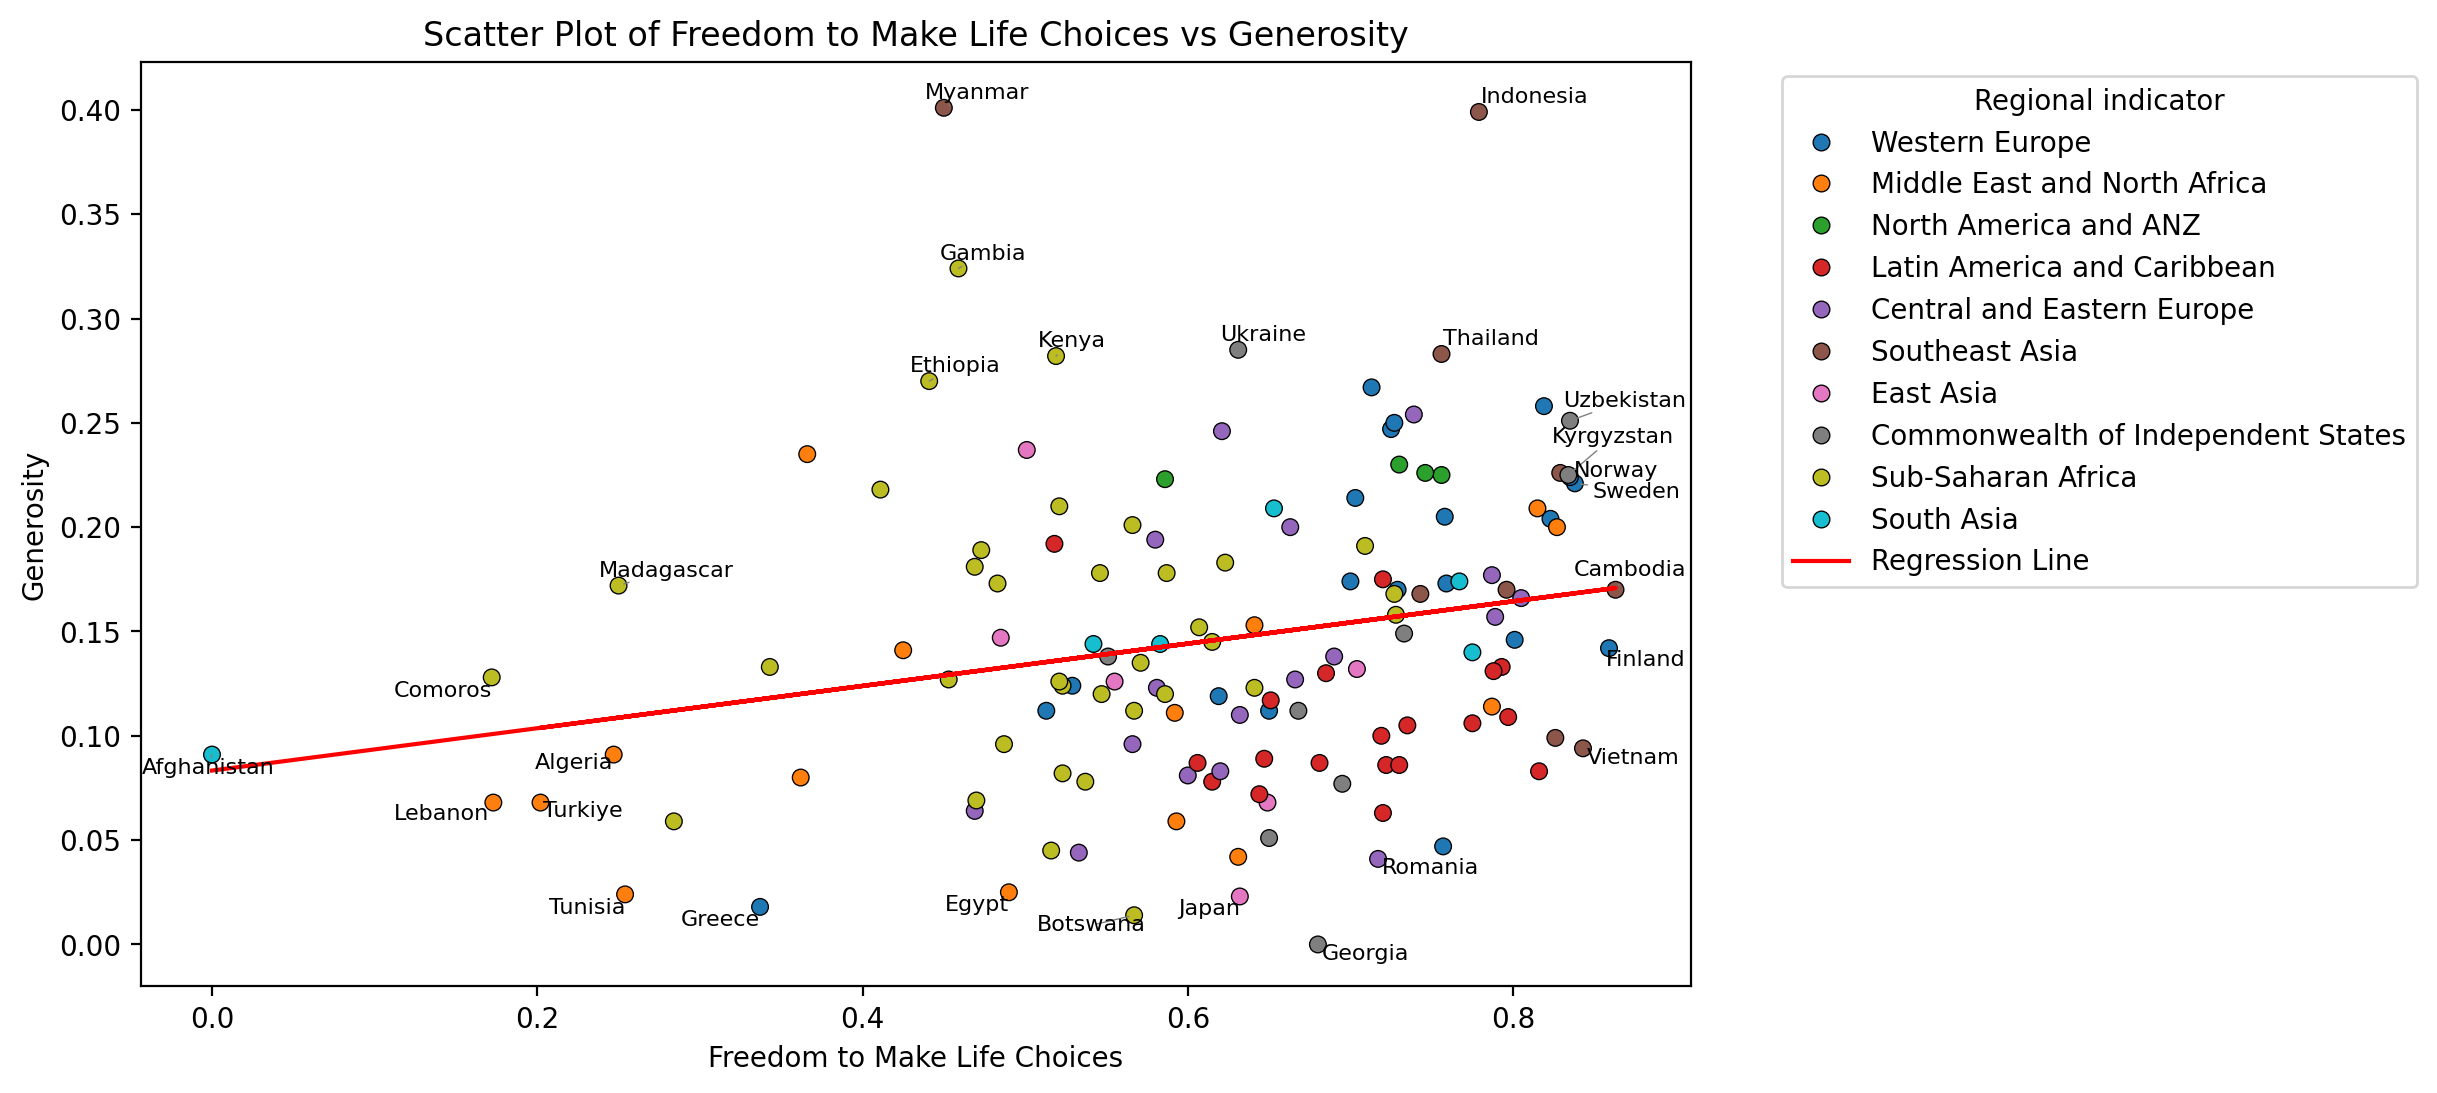

In [13]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Freedom_to_make_life_choices', y='Generosity', data=happiness_2024, hue='Regional_indicator', palette=region_colours, edgecolor='black')

texts=[]
for i in range(len(highlight_countries_free_generous)):
    country_name = highlight_countries_free_generous['Country_name'].iloc[i]
    x = highlight_countries_free_generous['Freedom_to_make_life_choices'].iloc[i]
    y = highlight_countries_free_generous['Generosity'].iloc[i]
    
    # Change alignment depending on the quadrant of the point to vary positioning
    ha = 'left' if x > happiness_2024['Freedom_to_make_life_choices'].median() else 'right'
    va = 'bottom' if y > happiness_2024['Generosity'].median() else 'top'
    
    # Store the text object in the list for adjustText
    texts.append(plt.text(x, y, country_name, fontsize=8, ha=ha, va=va, color='black'))

adjust_text(texts, arrowprops=dict(arrowstyle='-',color='grey', lw=0.5))

x_vals = happiness_2024['Freedom_to_make_life_choices']
y_vals = model_freedom.predict(pd.DataFrame({'Freedom_to_make_life_choices': x_vals}))

# Plot the regression line
plt.plot(x_vals, y_vals, color='red', label='Regression Line')

# Title and labels
plt.title('Scatter Plot of Freedom to Make Life Choices vs Generosity')
#plt.xlabel('Ladder score')
plt.xlabel('Freedom to Make Life Choices')
plt.ylabel('Generosity')
plt.legend(title='Regional indicator', bbox_to_anchor=(1.05, 1), loc='upper left')

# Show plot
plt.show()

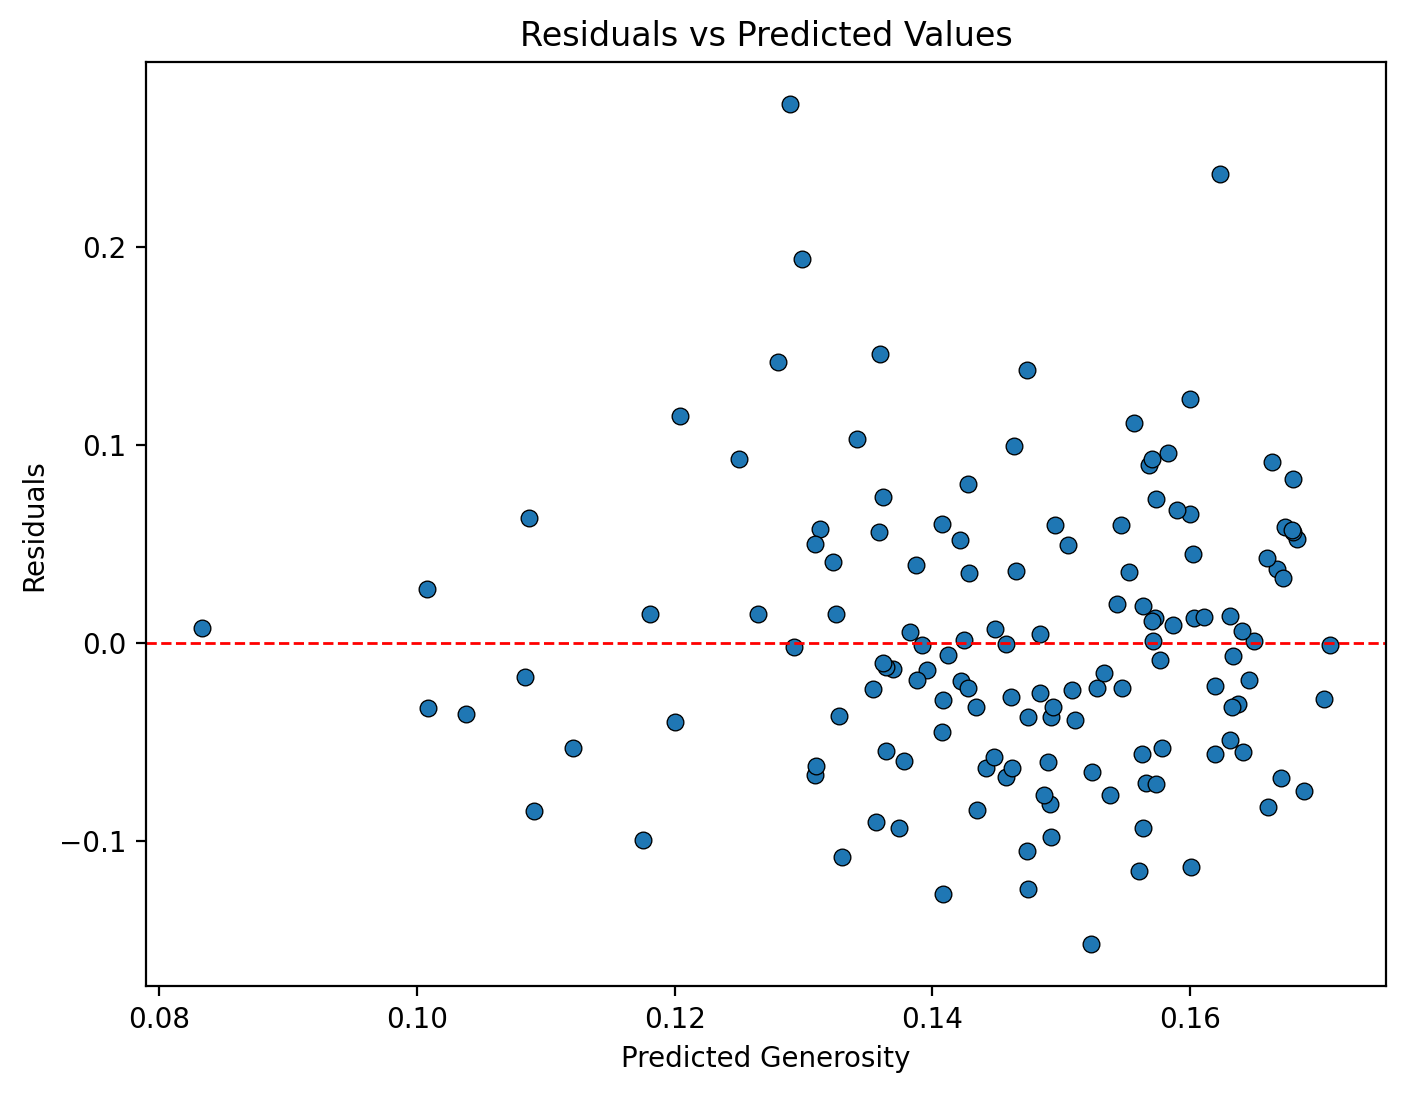

In [14]:
# Calculate residuals and predicted values
happiness_2024['Predicted_generous'] = model_freedom.predict(happiness_2024)
happiness_2024['Residuals_generous'] = happiness_2024['Generosity'] - happiness_2024['Predicted_generous']

# Plot residuals vs predicted values
plt.figure(figsize=(8, 6))
sns.scatterplot(x='Predicted_generous', y='Residuals_generous', data=happiness_2024, edgecolor='black')
plt.axhline(0, color='red', linestyle='--', linewidth=1)
plt.title('Residuals vs Predicted Values')
plt.xlabel('Predicted Generosity')
plt.ylabel('Residuals')
plt.show()


**Interpretation of these results**:
- $p$-value = 0.008 $<$ 0.05. So we do not accept the Null Hypothesis ($H_0$). The predictor variable, Freedom to Make Life Choices, does significantly influence the dependent variable, Generosity.
- The $R^2$ vaue of 0.050 is a measure of the variation of this regression model. The positive value for $R^2$ suggests that the model's prediction of Generosity is better than just predicting it based off the mean. According to this value, we would claim that Freedom to Make Life Choices accounts for 5% of the variance of Generosity.
- Adjusted $R^2$ is in practise a more reliable meaure for the goodness of fit - the value 0.043 is sufficiently close to 0.050 to be satisfied with this model's reliability, since we know that there are other factors influencing these complex variables.
- The residuals are scattered around 0 with no clear pattern, which indicates that linearity is validated.
  
**Concluding the result of this test**:
- The conclusion can be reached from this data that, with a 95% significance level, Freedom to Make Life Choices has a positive effect on Generosity, accounting for up to 5% of the variance of this dependent variable. The strength of influence based on the coefficient 0.1014 is weak; we can only explain a small change in generosity. To predict accurately how generous the people of a given country are, we would need to factor in many more elements to our analysis. The outliers in the plot such as Myanmar, where according to this data the people are highly generous but only averagely free in their choices, would suggest that other factors might play a large role. 

# Multiple Linear Regression Hypothesis Test for Predicting the Ladder Score
Here I lay out a plan for analysing the way the predictor variables influence the Ladder Score globally, by fitting a multiple liner regression model:
1. Define the Variables
2. Formulate Hypotheses
3. Sepcify the model
4. Fit the model
5. Improve the model
6. Test the hypotheses
7. Assess the Model Fit
8. Validate assumptions by Statistical Tests
9. Explore Possible Biases in the Data Contextually
10. Interpret results

**1. Define the Variables**:
Let's investiate what effect there is of the six predictor variables on the reported subjective variable of Ladder score. We will encode the variables as follows:
- $X_1$ : GDP per Capita
- $X_2$ : Generosity
- $X_3$ : Life Expectancy
- $X_4$ : Freedom to Make Life Choices
- $X_5$ : Social Support
- $X_6$ : Perceptions of Corruption

**2. Formulating Hypotheses**:
For each predictor $X_i$ as listed above, we will formulate the hypotheses as follows:
- **Null Hypothesis** $(H^i_0)$ : The predictor $X_i$ does not significantly influence the Ladder Score. ($\beta_i = 0$)
- **Alternative Hypothesis** $(H^i_A)$ : The predictor $X_i$ does significantly influence the Ladder Score. ($\beta_i \neq 0$)

Significance Level: Let us choose a significance level of 95% for this analysis. For each predictor if $p$-value $<$ 0.05, we will reject the null hypothesis and conclude that the predictor significantly influences the ladder score. For each predictor if $p$-value $\geq$ 0.05, we will accept the null hypothesis and conclude that the predictor does not significantly influence the ladder score.


**3. Specify the Model**

The variables in the study were chosen because the researchers found that they had an influence on life satisfaction, so we want to model for Ladder Score with all of them and see if some can be removed from the model. Let's start with a multiple linear regression model for the Ladder Score $( Y )$ based on the six predictors as follows:

$$
\text{Ladder Score} = \beta_0 + \beta_1 \cdot \text{Log GDP per Capita} + \beta_2 \cdot \text{Generosity} + \beta_3 \cdot \text{Healthy Life Expectancy} + \beta_4 \cdot \text{Freedom to Make Life Choices} + \beta_5 \cdot \text{Social Support} + \beta_6 \cdot \text{Perceptions of Corruption} + \epsilon
$$

Where:
- $\beta_0 $ : Intercept term
- $ \beta_1, \beta_2, \beta_3, \beta_4, \beta_5, \beta_6 $ : Coefficients for the respective predictors
- $ \epsilon $ : Error term

**4. Fit the Model**

Use ordinary least squares (OLS) regression to estimate the coefficients:

In [18]:
# Fit the OLS regression model
model = smf.ols('Ladder_score ~ Log_GDP_per_capita + Generosity + Healthy_life_expectancy + Freedom_to_make_life_choices + Social_support + Perceptions_of_corruption', data=happiness_2024).fit()

# View the summary
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:           Ladder_score   R-squared:                       0.819
Model:                            OLS   Adj. R-squared:                  0.811
Method:                 Least Squares   F-statistic:                     100.6
Date:                Wed, 20 Nov 2024   Prob (F-statistic):           5.73e-47
Time:                        19:52:57   Log-Likelihood:                -101.65
No. Observations:                 140   AIC:                             217.3
Df Residuals:                     133   BIC:                             237.9
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Intercept       

**5. Improve on the model**

This model gives an interesting result. The $p$-values are below 0.05 for all predictor variables except for generosity (which coincides with the visual inference based on the scatter plots and the slope of the regression lines for each variable modelling for Ladder Score individually). 

So what happens if we now run a new model reduced to exclude Generosity?

Interestingly the intercept for Generosity is higher than that of log GDP per capita, suggesting a greater influence, but a less statistically significant one given the links between variables.

In [19]:
# Fit the reduced OLS regression model
model_reduced = smf.ols('Ladder_score ~ Log_GDP_per_capita + Healthy_life_expectancy + Freedom_to_make_life_choices + Social_support + Perceptions_of_corruption', data=happiness_2024).fit()

# Print the summary
print(model_reduced.summary())


                            OLS Regression Results                            
Dep. Variable:           Ladder_score   R-squared:                       0.819
Model:                            OLS   Adj. R-squared:                  0.812
Method:                 Least Squares   F-statistic:                     121.0
Date:                Wed, 20 Nov 2024   Prob (F-statistic):           6.43e-48
Time:                        19:52:59   Log-Likelihood:                -101.93
No. Observations:                 140   AIC:                             215.9
Df Residuals:                     134   BIC:                             233.5
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Intercept       

**6. Test the hypotheses**

Now we have a model where all the $p$-vlaues of our predictor variables (aside from Generosity) are less than 0.05, fitting the conditions we set initially for rejecting the Null Hypotheses for those variables. Pending validation of our assumptions to ensure that the test results are valid, we will most likely reject those Null Hypotheses. 

**7. Assess the Model Fit**

So we accept the idea that there is a statistically significant influence of these variables on the Ladder Score. But how strong is that influence? 
Looking at the $R^2$ value of 0.819 and the adjusted $R^2$ of 0.812, we have a model that could predict 81% of the variance of the Ladder Score. For the purposes of our study, given how subjective this data is and how complex the many factors influencing life satisfaction appear to be, that is contextually a strong model fit. 

**8. Validate Assumptions by Statistical Tests**

But before we make concluding claims on these relationships, we need to rigorously ensure the regression model assumptions are met: linearity, independence, normality of residuals, no (high, significant) multicollinearity. 

We know that the predictor variables are independent because they are simply conveying infromation arising in the real world outside of the control of the study; the corruption score given in the data for Afghanistan does not have an effect on the Social Support score for Afghanistan (or any other country). 

For linearity, we observe the scatter plot of residuals vs predicted Ladder Score values and find that there is no particular pattern; this is good as it demonstrates there is no 'hidden' nonlinear relationship. 

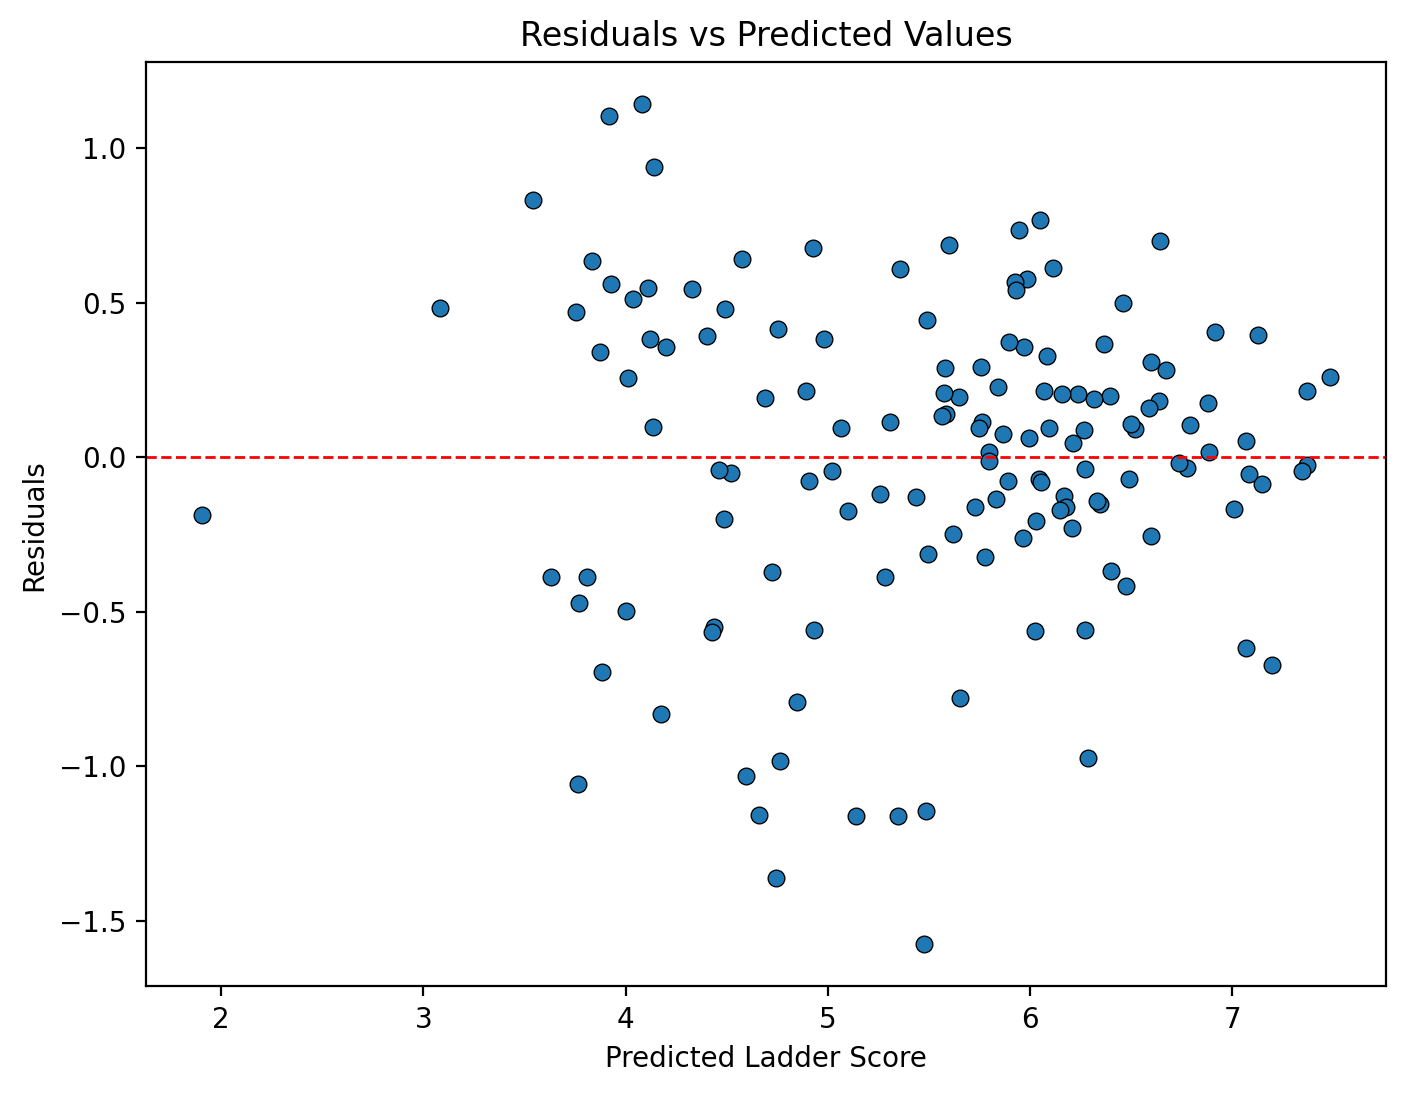

In [20]:
# Calculate residuals and predicted values
happiness_2024['Predicted'] = model_reduced.predict(happiness_2024)
happiness_2024['Residuals'] = happiness_2024['Ladder_score'] - happiness_2024['Predicted']

# Plot residuals vs predicted values
plt.figure(figsize=(8, 6))
sns.scatterplot(x='Predicted', y='Residuals', data=happiness_2024, edgecolor='black')
plt.axhline(0, color='red', linestyle='--', linewidth=1)
plt.title('Residuals vs Predicted Values')
plt.xlabel('Predicted Ladder Score')
plt.ylabel('Residuals')
plt.show()


Now plotting a Q-Q Plot of Residuals will confirm visually that the residuals are normally distributed if the residuals fall approximately along a diagonal line. We observe below that this is indeed the case.

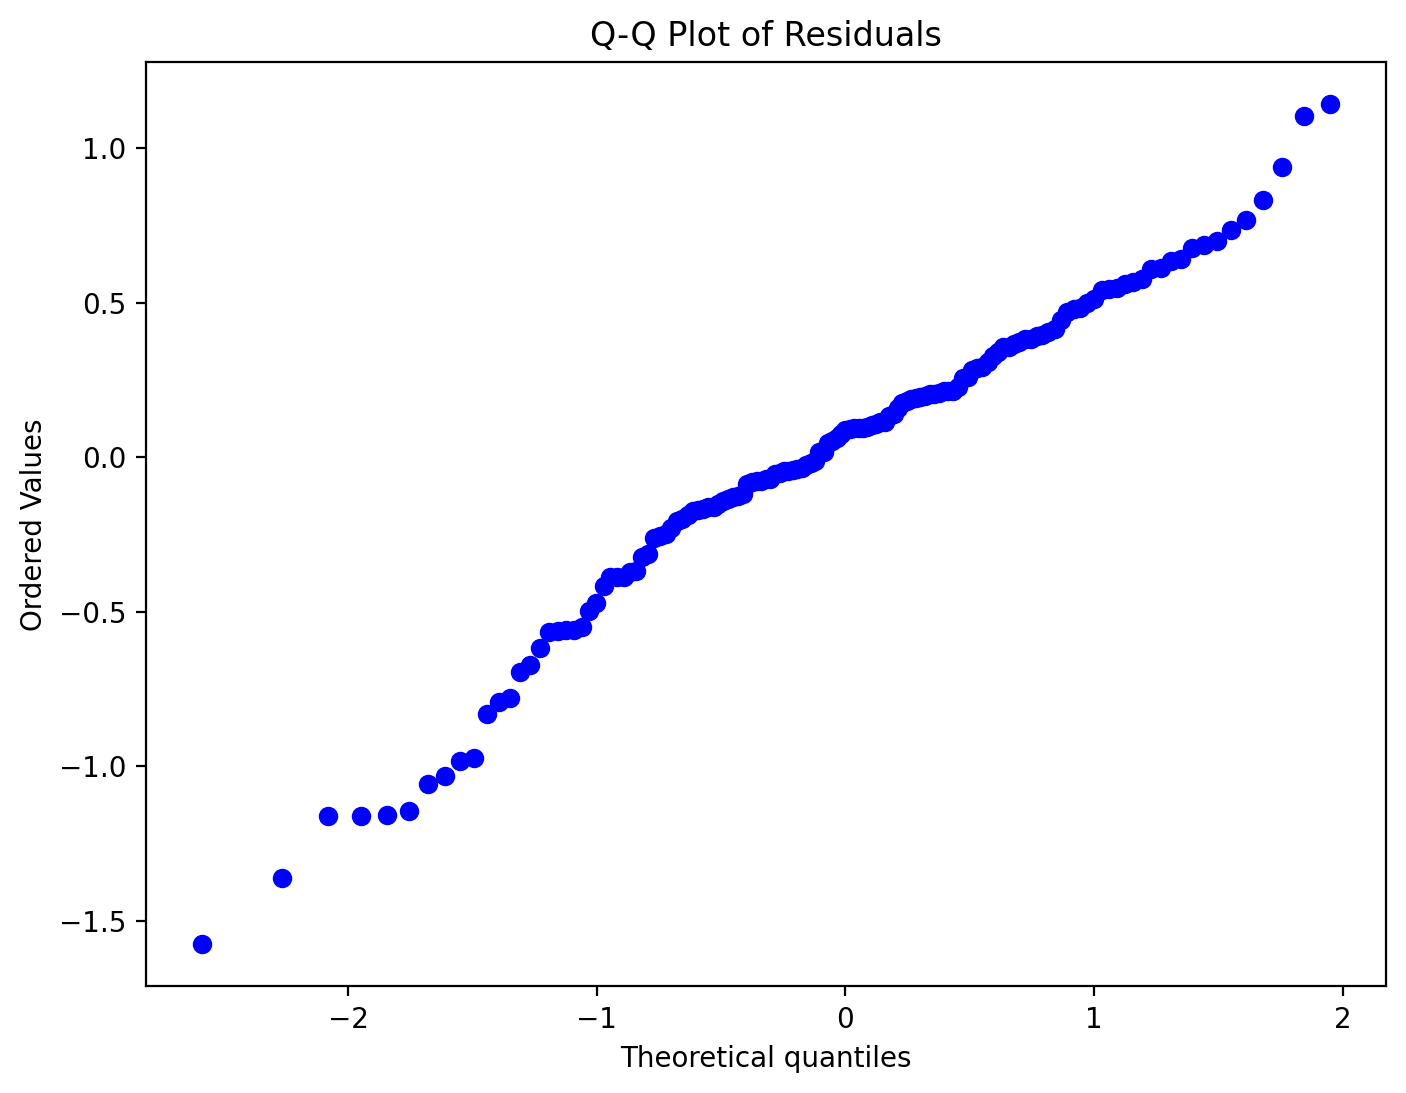

In [21]:
import scipy.stats as stats

# Q-Q Plot for residuals
plt.figure(figsize=(8, 6))
stats.probplot(happiness_2024['Residuals'], dist="norm", plot=plt)
plt.title('Q-Q Plot of Residuals')
plt.show()


Next, a test for high multicollinearity: the Variance Inflation Factor (VIF) for each of the predictor variables gives us a measure of its aggregated multicolinearity with the other variables. As a general rule, where VIF > 5, the multicollinearity is problematic. These results are satisfactory in their indication that, while there is some multicollinearity, it is not too high. 

In [22]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
# Caluclate VIF for each predictor
vif_data = pd.DataFrame()
vif_data['Feature'] = model_reduced.model.exog_names
vif_data['VIF'] = [variance_inflation_factor(model_reduced.model.exog, i) for i in range(model_reduced.model.exog.shape[1])]
print(vif_data)

                        Feature        VIF
0                     Intercept  20.242307
1            Log_GDP_per_capita   3.938792
2       Healthy_life_expectancy   3.505485
3  Freedom_to_make_life_choices   1.404241
4                Social_support   2.579578
5     Perceptions_of_corruption   1.353296


For comparison's sake, the VIF for the previous model which included generosity is shown below. Generosity does not have a high VIF, but (as we should expect) does very slightly increase the VIF for each of the other predictor variables, compared with the values from model_reduced.

In [23]:
# Calculate VIF for each predictor
vif_data = pd.DataFrame()
vif_data['Feature'] = model.model.exog_names
vif_data['VIF'] = [variance_inflation_factor(model.model.exog, i) for i in range(model.model.exog.shape[1])]
print(vif_data)

                        Feature        VIF
0                     Intercept  22.768359
1            Log_GDP_per_capita   4.157293
2                    Generosity   1.146337
3       Healthy_life_expectancy   3.508979
4  Freedom_to_make_life_choices   1.454670
5                Social_support   2.625614
6     Perceptions_of_corruption   1.409850


The conditions for these fundamental assumptions which justify regression inference are validated. So our statistical work is done, and it remains to look critically at the data contextually and qualitatively, then make our final inferential assessment. 

**9. Explore Possible Biases in the Data Contextually**

We can now argue that _quantitatively_ speaking, for a given country, if we knew its GDP, healthy life expectancy, quantified levels of freedom, social support and corruption, then we could make a good prediction of where the people of that country would, on average, place themselves on the Life Satisfaction Ladder. But we must scrutinise the process of this study in context.

What of the validity of the questions the study is composed of, who is asking them and who is being asked? 

In [24]:
# Function to check if a search string exists in any row
def search_string(s, search):
    return search.lower() in str(s).lower()

# Create a mask by applying the search_string function to each element in the dataframe
mask = happiness_2024.applymap(lambda s: search_string(s, 'North Korea'))

# Filter the dataframe to rows where the mask is True for any column
filtered_df = happiness_2024.loc[mask.any(axis=1)]

# Print the filtered dataframe
print(filtered_df)


Empty DataFrame
Columns: [Country_name, Regional_indicator, Ladder_score, upperwhisker, lowerwhisker, Log_GDP_per_capita, Social_support, Healthy_life_expectancy, Freedom_to_make_life_choices, Generosity, Perceptions_of_corruption, Dystopia_+_residual, Predicted_generous, Residuals_generous, Predicted, Residuals]
Index: []


**Missing Countries and Occupied or Disputed Territories**

It must first be said that there are parts of the world not represented and mis-represented. The search and filter function above this text enabled me to investigate some individual cases in the data, considering occupied, disputed and isolated territories. North Korea is not included despite being a member of the United Nations. Kosovo is not a UN member (though it is recognised as a state by 104 members) but is included in the list. So the inclusion criteria are not on a one-size-fits-all basis.

Disputed and occupied territories show further inconsistencies. Kashmir is a disputed territory with a self-determination movement whose lands would fall into India or Pakistan, which each hold a military occupation over a part of Kashmir. It is not independently surveyed, so we must assume that the Kashmiri people occupied by India are taken into account in the survey of India, and likewise for the people in the part of Kashmir occupied by Pakistan. 

Contrastingly, the State of Palestine is surveyed separately from Israel, despite being under military occupation (Palestine has only Ladder score data and none of the other predictors - so is not included in any of the regression analysis). So the ladder score for Israel does not take into account the life satisfaction of the Palestinian people under Israeli occupation, but the ladder score for India does take into account the life satisfaction of the Kashmiri people under Indian occupation. Whilst the Kashmiris make up a much smaller percentage of the population of Indian-controlled land than the Palestinians do in Israeli-controlled land, this does nonethless render a certain invalidity to comparison between the relative life satisfaction of India and Israel. We could further explore similar questions of other regions such as Crimea, Rojava or Western Sahara. The choices of how to interpret each territorial dispute inform the data that we have to go on.

**Linguistic and Cultural Bias**

Gallup is an American multinational analytics company based in Washington, DC founded in 1935. Oxford University is a 900-year-old public university at the heart of the British establishment. Why does this matter?

The cultural background of the surveying and reporting that leads to this data comes squarely from the Anglophone Global North countries. This leads to a question around linguistic and cultural translation; those who devised the survey inevitably brought their own biases with them to that process (try as they might not to). In surveying, the way a question is asked has an effect on how it is answered. It is very difficult to find any sentence for which the essence and nuance of the meaning translates perfectly into every language in the world, which the Cantril Ladder question has to do to be a valid universal measure of life satisfaction. 

The cultural bias in this type of subjective data has been documented and studied in an OECD report asking 'Does Culture Matter?' (Exton et al, 2015). The researchers considered several issuesof cultural biases, such as international differences in appraisal styles and the experience of migrants' affects on others. They conclude that "although life circumstances explain well the overall pattern of cross-country variation in subjective well-being, a gap is observed for some countries. Culture may account for some 20% of the country-specific unexplained variance. This combined effect of “cultural impact” and “cultural bias” is small when compared to the role of objective life circumstances inexplaining subjective well-being outcomes." So, although they found that there were notable issues with the WHR's subjective well-being data due to cultural biases, they affirm the WHR's assumption that objective differences such as GDP, life expectancy or social support structures have a stronger impact. 

**Critique of Predictor Variable Choice**

Even if we argue that the majority of variance between countries' life satisfaction levels is explainable due to objective life circumstances, we might question the choice of the particular predictor variables in the WHR model. Generosity wasn't found in the analysis here to be a necessary predictor to get the best estimates we could, adding more noise than signal to the model. Why limit the model to only five or six factors, when the world is so much more complex?

In the paper 'Critical Failures in the World Happiness Report’s Model of National Life Satisfaction: An Improved Specification and its Implications for Democracy' (Loewi, 2024), an alternative model for measuring life satisfaction, the Dovecote Model. Loewi uses the average life satisfaction data as reported by the WHR, but considers 5527 possible predictor variables for the model, finding "far more variables with meaningful contributions, very different contributions for the WHR's six variables including two out of six that can be removed entirely without significant consequences to fit, a strictly better model fit both in and out of sample, and a dramatically different interpretation of the results." Some of the other variables he adds are discrimination, political power and education. Loewi found that "while the reported model suggests GDP explains roughly 40% of model variation, we estimate the true direct contribution of economic indicators to be 2.3%." 

However some of the additional variables in Loewi's model are those which WHR states it does not include due to difficulty in obtaining that information across all the countries surveyed, so the Dovecote Model may suffer from more forced omissions of countries which lack data in all its predictor variables. The Dovecote work does make a strong argument that the WHR's chosen predictor variables are imperfect and should be further scrutinised.

**10. Conclusion: Interpreting Results**

Based on coefficients, the following would be an order of influence of the predictor variables on the dependent variable of Ladder Score (Life Satisfaction). 

From most to least:
1. Freedom to Make Life Choices
2. Social Support
3. Healthy Life Expectancy
4. Perceptions of Corruption
5. Generosity
6. Log GDP per Capita

But based on $p$-values, we eliminated Generosity from the model and the model improved, because the effect of Generosity could be explained by a composite effect of the other variables. 

So the conclusion is that $H^2_0$ is accepted, but for all other $i$ from 1 to 6, $H^i_0$ is rejected, with a 95% significance level. In other words, we are 95% confident that for a given country which is in the dataset the combined information of numerical values for Freedom, Social Support, Life Expectancy, Corruption, and GDP per capita will be a good predictor of the average Ladder Score for that country. 

The caveat would be that this data is incomplete, is collected in a highly subjective way, contains inherent cultural biases and should never be considered an absolute measure of Life Satisfaction; more detailed and well-thought-out models could improve upon these predictors. 

**Bibliography**

1. Helliwell, J. F., Layard, R., Sachs, J. D., De Neve, J.-E., Aknin, L. B., & Wang, S. (Eds.). (2024). World Happiness Report 2024. _University of Oxford: Wellbeing Research Centre_. https://worldhappiness.report/.

2. Exton, C., Smith, C., Vandendriessche, D. (2015). 'Comparing Happiness Across the World: Does Culture Matter?' _OECD Library._ https://dx.doi.org/10.1787/5jrqppzd9bs2-en.

3. Loewi, A. (2024). 'Critical Failures in the World Happiness Report’s Model of National Life Satisfaction: An Improved Specification and its Implications for Democracy.' _Dovecote Institute._ Retrieved November 14, 2024, from https://dovecoteinstitute.org/files/Loewi-Life-Satisfaction-2024.pdf.